In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [120]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    import re
    client_timestamps = {}
    for k,v in d["client_metrics"][0].iteritems():
        if re.compile(".+->.+_timestamps").match(k):
            client_timestamps[str(k)] = np.asarray(v)     
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    hollistic_data["client_timestamps"] = client_timestamps
    
    return result, hollistic_data

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

ID1_500, ID1_500_hollistic = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180312_012713.json", timestamps=True)

def clean_extraction(extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        extraction[key] = value[value.shape[0]/20:] # cut off the first fourth from warmup effects

clean_extraction(ID1_500)
clean_extraction(ID1_500_resnet2)
        
for key, value in ID1_500_resnet2.iteritems():
    print key, value.shape

tf-resnet-feats:1:queue_sizes (40904, 2)
app:tf-kernel-svm:prediction_latencies (27008, 2)
tf-kernel-svm:processing_latency (27009, 2)
model:tf-resnet-feats:1:prediction_latencies_list (13906, 2)
tf-kernel-svm:1:queue_arrivals (27011, 2)
app:tf-resnet-feats:prediction_latencies (26872, 2)
model:inception:1:prediction_latencies_list (17034, 2)
tf-log-reg:processing_latency (27016, 2)
app:inception:prediction_latencies (26870, 2)
inception:1:queue_sizes (44023, 2)
app:tf-log-reg:prediction_latencies (27013, 2)
model:tf-log-reg:1:prediction_latencies_list (27016, 2)
tf-resnet-feats:processing_latency (13905, 2)
tf-resnet-feats:1:processing_outs (22736, 2)
tf-resnet-feats:1:queue_arrivals (27008, 2)
tf-kernel-svm:1:queue_sizes (54017, 2)
tf-log-reg:1:queue_arrivals (27016, 2)
inception:processing_latency (17031, 2)
tf-log-reg:1:queue_sizes (54031, 2)
tf-log-reg:1:processing_outs (27016, 2)
tf-kernel-svm:1:processing_outs (27010, 2)
inception:1:queue_arrivals (27010, 2)
inception:1:processi

In [121]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        processing_time = processing_time[processing_time<1e3]
        serving_time = serving_time[serving_time<1e3]
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15)

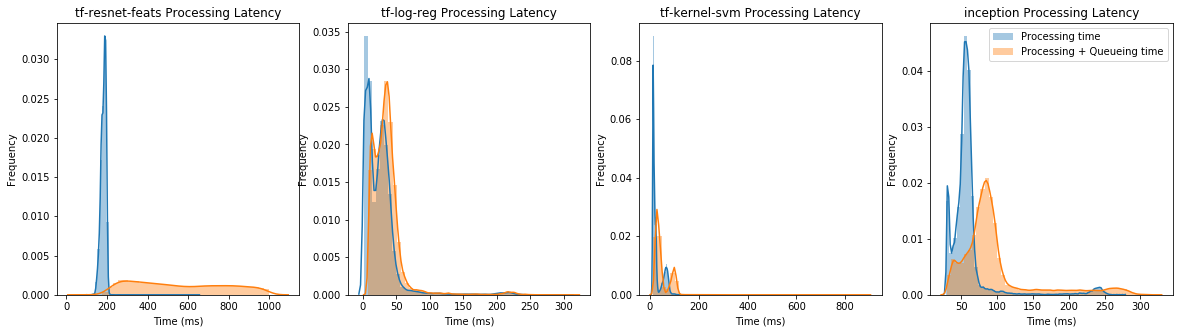

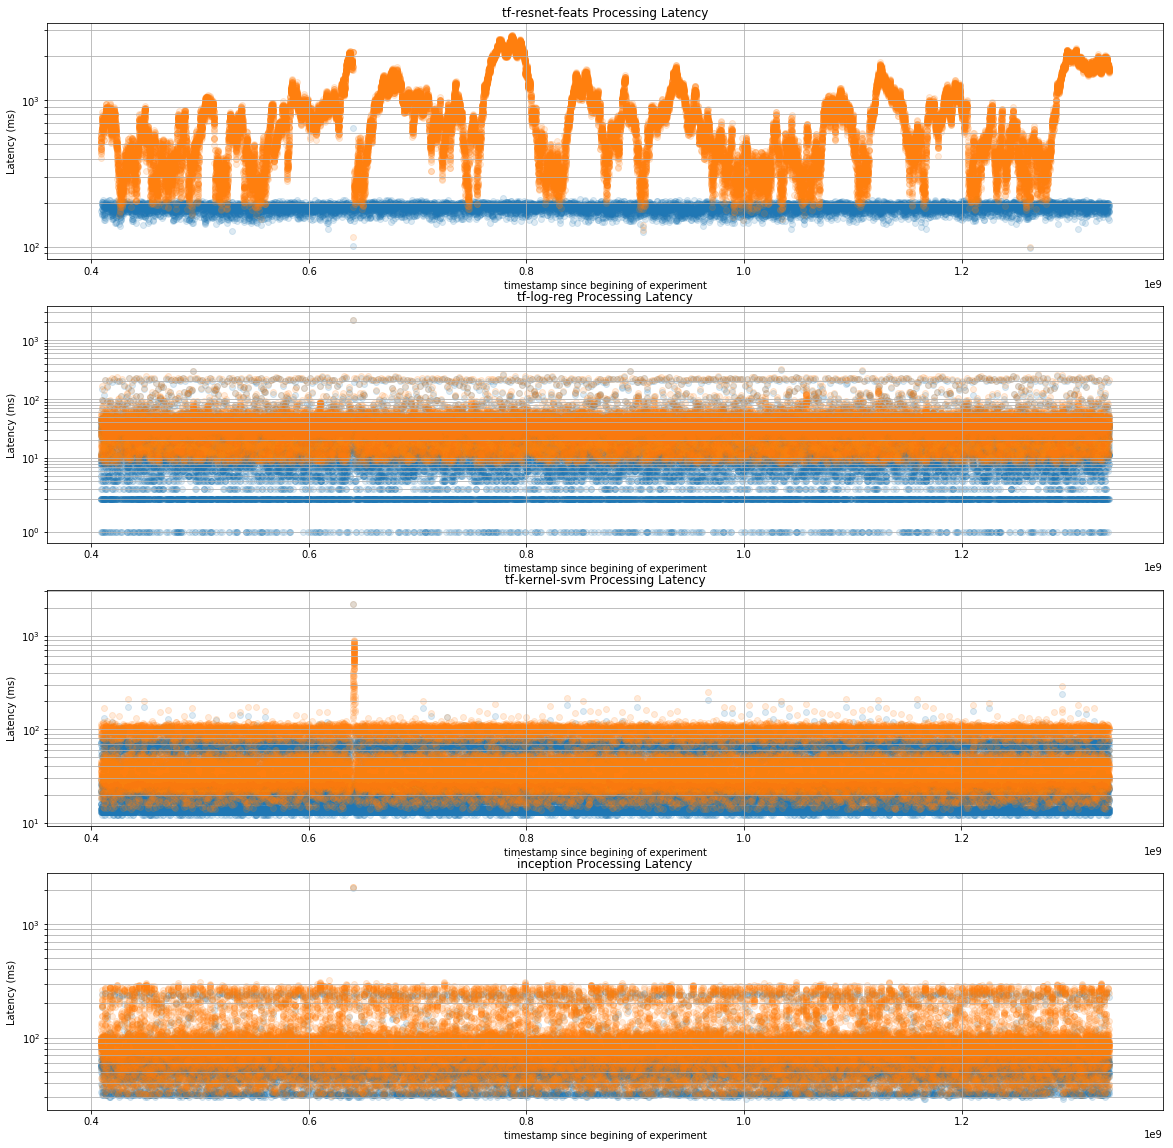

In [122]:
compare_latency_dists(ID1_500, image_driver_1_models)
compare_latency_dists_over_time(ID1_500, image_driver_1_models)

In [10]:
def get_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        intervals, _ = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        smoothLineHistogram(intervals, label=model+str(" CV="+str(CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        intervals, timestamps = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([np.min(intervals), np.max(intervals)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, intervals, label="CV="+str(CV), alpha = 0.3)
        plt.legend()
    plt.show()


In [ ]:
plot_inter_arrival_over_time(ID1_500, image_driver_1_models, intra_batch_arrivals=True)
plot_inter_arrival(ID1_500, image_driver_1_models, intra_batch_arrivals=True)

In [123]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

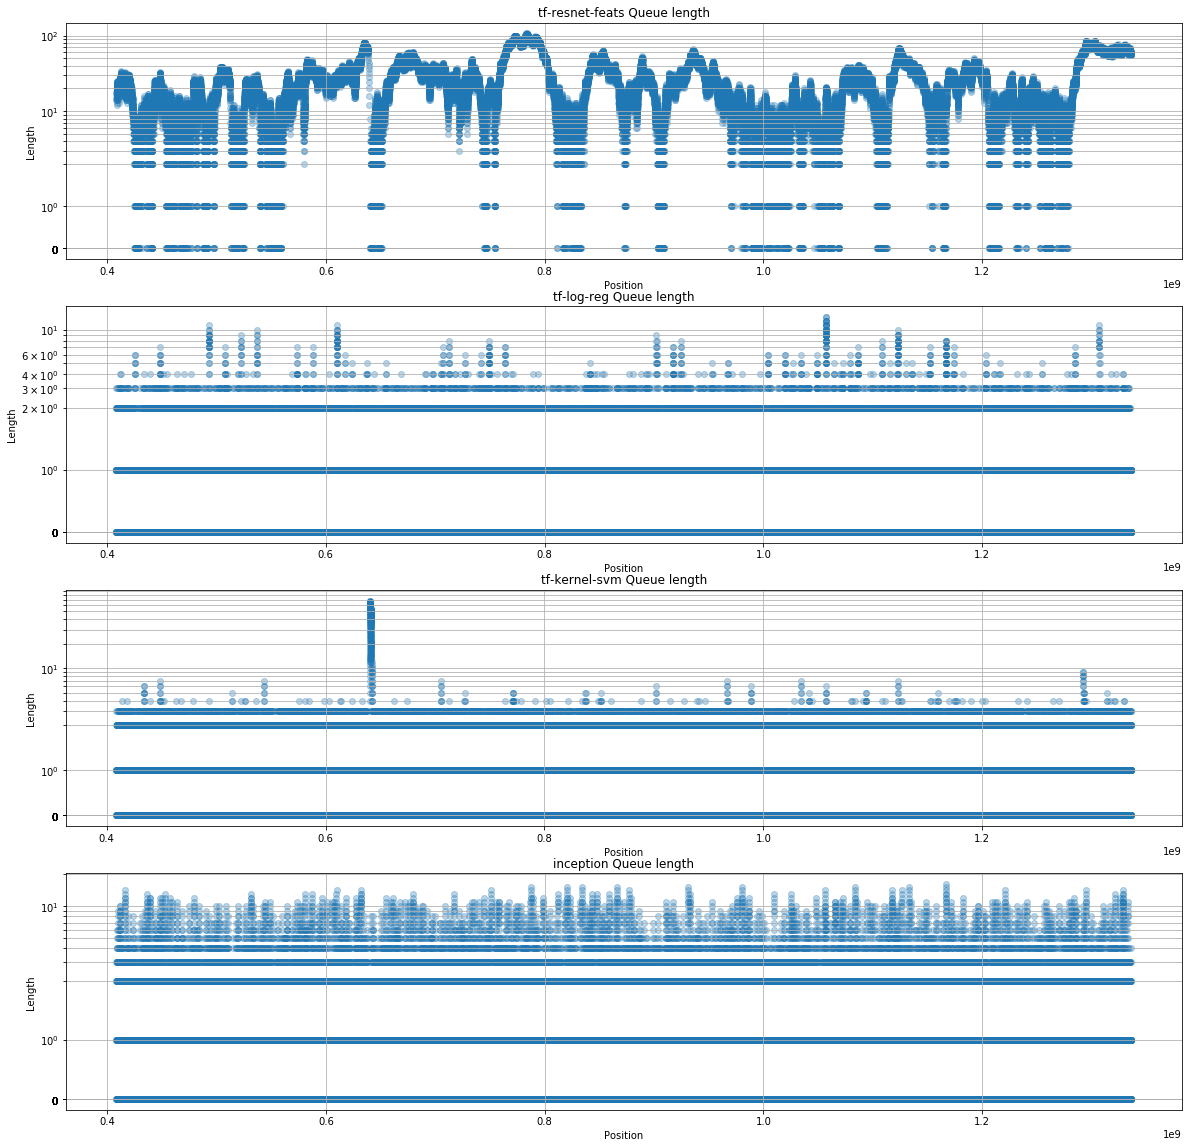

In [124]:
plot_ordinal_queue_sizes(ID1_500, image_driver_1_models)

In [104]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.scatter(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

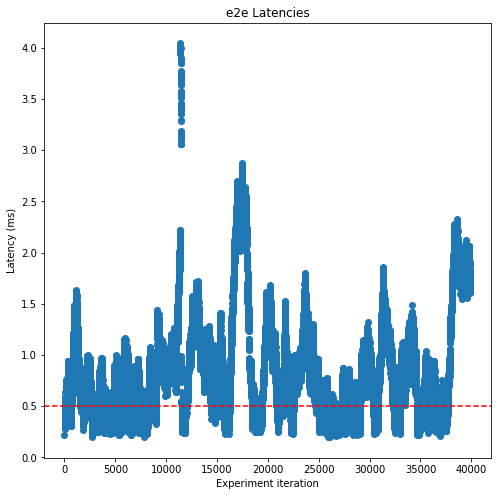

In [105]:
plot_e2e_lats(ID1_500_hollistic)

In [137]:
def get_max_curve(timestamps, trial_range):
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
    y_axis = np.asarray([get_smallest_delta_2(float(i), timestamps) for i in trial_range])
    x_axis = np.asarray(list(trial_range))
    return x_axis, y_axis

In [135]:
[(k, len(v)) for k,v in ID1_500_hollistic["client_timestamps"].iteritems()]

[('start->tf-resnet-feats_timestamps', 40000),
 ('inception->tf-log-reg_timestamps', 39998),
 ('start->inception_timestamps', 40000),
 ('tf-kernel-svm->join_timestamps', 39998),
 ('join->end_timestamps', 39997),
 ('tf-log-reg->join_timestamps', 39997),
 ('tf-resnet-feats->tf-kernel-svm_timestamps', 39999)]

In [150]:
x_range = xrange(1,45000,200)
resnet_arrival = ID1_500_hollistic["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
resnet_departure = ID1_500_hollistic["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet, y_arrival_resnet = get_max_curve(resnet_arrival, x_range)
x_departure_resnet, y_departure_resnet = get_max_curve(resnet_departure, x_range)

In [141]:
def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            print tail_index, head_index, position, contained_currently, max_so_far
            if contained_currently > max_so_far:
                best_position = position, tail_index, head_index
                max_so_far = contained_currently
        return max_so_far

get_smallest_delta_2(26, resnet_departure)

0 1 head 2 1
1 1 tail 1 2
1 2 head 2 2
1 3 head 3 2
1 4 head 4 3
1 5 head 5 4
2 5 tail 4 5
3 5 tail 3 5
4 5 tail 2 5
5 5 tail 1 5
5 6 head 2 5
5 7 head 3 5
5 8 head 4 5
5 9 head 5 5
6 9 tail 4 5
7 9 tail 3 5
8 9 tail 2 5
9 9 tail 1 5
9 10 head 2 5
9 11 head 3 5
9 12 head 4 5
9 13 head 5 5
10 13 tail 4 5
11 13 tail 3 5
12 13 tail 2 5
13 13 tail 1 5
13 14 head 2 5
13 15 head 3 5
13 16 head 4 5
13 17 head 5 5
14 17 tail 4 5
15 17 tail 3 5
16 17 tail 2 5
17 17 tail 1 5
17 18 head 2 5
17 19 head 3 5
17 20 head 4 5
17 21 head 5 5
18 21 tail 4 5
19 21 tail 3 5
20 21 tail 2 5
21 21 tail 1 5
21 22 head 2 5
21 23 head 3 5
22 23 tail 2 5
23 23 tail 1 5
23 24 head 2 5
23 25 head 3 5
23 26 head 4 5
23 27 head 5 5
24 27 tail 4 5
25 27 tail 3 5
26 27 tail 2 5
27 27 tail 1 5
27 28 head 2 5
27 29 head 3 5
27 30 head 4 5
27 31 head 5 5
28 31 tail 4 5
29 31 tail 3 5
30 31 tail 2 5
31 31 tail 1 5
31 32 head 2 5
31 33 head 3 5
31 34 head 4 5
31 35 head 5 5
32 35 tail 4 5
33 35 tail 3 5
34 35 tail 2 5
35 35

327 328 head 2 5
327 329 head 3 5
327 330 head 4 5
327 331 head 5 5
328 331 tail 4 5
329 331 tail 3 5
330 331 tail 2 5
331 331 tail 1 5
331 332 head 2 5
331 333 head 3 5
331 334 head 4 5
331 335 head 5 5
332 335 tail 4 5
333 335 tail 3 5
334 335 tail 2 5
335 335 tail 1 5
335 336 head 2 5
335 337 head 3 5
335 338 head 4 5
335 339 head 5 5
336 339 tail 4 5
337 339 tail 3 5
338 339 tail 2 5
339 339 tail 1 5
339 340 head 2 5
339 341 head 3 5
339 342 head 4 5
339 343 head 5 5
340 343 tail 4 5
341 343 tail 3 5
342 343 tail 2 5
343 343 tail 1 5
343 344 head 2 5
343 345 head 3 5
343 346 head 4 5
343 347 head 5 5
344 347 tail 4 5
345 347 tail 3 5
346 347 tail 2 5
347 347 tail 1 5
347 348 head 2 5
347 349 head 3 5
347 350 head 4 5
347 351 head 5 5
348 351 tail 4 5
349 351 tail 3 5
350 351 tail 2 5
351 351 tail 1 5
351 352 head 2 5
351 353 head 3 5
351 354 head 4 5
351 355 head 5 5
352 355 tail 4 5
353 355 tail 3 5
354 355 tail 2 5
355 355 tail 1 5
355 356 head 2 5
355 357 head 3 5
355 358 head 4

631 634 head 4 6
631 635 head 5 6
632 635 tail 4 6
633 635 tail 3 6
634 635 tail 2 6
635 635 tail 1 6
635 636 head 2 6
635 637 head 3 6
635 638 head 4 6
635 639 head 5 6
636 639 tail 4 6
637 639 tail 3 6
638 639 tail 2 6
639 639 tail 1 6
639 640 head 2 6
639 641 head 3 6
639 642 head 4 6
639 643 head 5 6
640 643 tail 4 6
641 643 tail 3 6
642 643 tail 2 6
643 643 tail 1 6
643 644 head 2 6
643 645 head 3 6
643 646 head 4 6
643 647 head 5 6
644 647 tail 4 6
645 647 tail 3 6
646 647 tail 2 6
647 647 tail 1 6
647 648 head 2 6
647 649 head 3 6
647 650 head 4 6
647 651 head 5 6
648 651 tail 4 6
649 651 tail 3 6
650 651 tail 2 6
651 651 tail 1 6
651 652 head 2 6
651 653 head 3 6
651 654 head 4 6
651 655 head 5 6
652 655 tail 4 6
653 655 tail 3 6
654 655 tail 2 6
655 655 tail 1 6
655 656 head 2 6
655 657 head 3 6
655 658 head 4 6
655 659 head 5 6
656 659 tail 4 6
657 659 tail 3 6
658 659 tail 2 6
659 659 tail 1 6
659 660 head 2 6
659 661 head 3 6
659 662 head 4 6
659 663 head 5 6
660 663 tail 4

927 931 head 5 6
928 931 tail 4 6
929 931 tail 3 6
930 931 tail 2 6
931 931 tail 1 6
931 932 head 2 6
931 933 head 3 6
931 934 head 4 6
931 935 head 5 6
932 935 tail 4 6
933 935 tail 3 6
934 935 tail 2 6
935 935 tail 1 6
935 936 head 2 6
935 937 head 3 6
935 938 head 4 6
935 939 head 5 6
936 939 tail 4 6
937 939 tail 3 6
938 939 tail 2 6
939 939 tail 1 6
939 940 head 2 6
939 941 head 3 6
939 942 head 4 6
939 943 head 5 6
940 943 tail 4 6
941 943 tail 3 6
942 943 tail 2 6
943 943 tail 1 6
943 944 head 2 6
943 945 head 3 6
943 946 head 4 6
943 947 head 5 6
944 947 tail 4 6
945 947 tail 3 6
946 947 tail 2 6
947 947 tail 1 6
947 948 head 2 6
947 949 head 3 6
947 950 head 4 6
947 951 head 5 6
948 951 tail 4 6
949 951 tail 3 6
950 951 tail 2 6
951 951 tail 1 6
951 952 head 2 6
951 953 head 3 6
951 954 head 4 6
951 955 head 5 6
952 955 tail 4 6
953 955 tail 3 6
954 955 tail 2 6
955 955 tail 1 6
955 956 head 2 6
955 957 head 3 6
955 958 head 4 6
955 959 head 5 6
956 959 tail 4 6
957 959 tail 3

1231 1235 head 5 6
1232 1235 tail 4 6
1233 1235 tail 3 6
1234 1235 tail 2 6
1235 1235 tail 1 6
1235 1236 head 2 6
1235 1237 head 3 6
1235 1238 head 4 6
1235 1239 head 5 6
1236 1239 tail 4 6
1237 1239 tail 3 6
1238 1239 tail 2 6
1239 1239 tail 1 6
1239 1240 head 2 6
1239 1241 head 3 6
1239 1242 head 4 6
1239 1243 head 5 6
1240 1243 tail 4 6
1241 1243 tail 3 6
1242 1243 tail 2 6
1243 1243 tail 1 6
1243 1244 head 2 6
1243 1245 head 3 6
1243 1246 head 4 6
1243 1247 head 5 6
1244 1247 tail 4 6
1245 1247 tail 3 6
1246 1247 tail 2 6
1247 1247 tail 1 6
1247 1248 head 2 6
1247 1249 head 3 6
1247 1250 head 4 6
1247 1251 head 5 6
1248 1251 tail 4 6
1249 1251 tail 3 6
1250 1251 tail 2 6
1251 1251 tail 1 6
1251 1252 head 2 6
1251 1253 head 3 6
1251 1254 head 4 6
1251 1255 head 5 6
1252 1255 tail 4 6
1253 1255 tail 3 6
1254 1255 tail 2 6
1255 1255 tail 1 6
1255 1256 head 2 6
1255 1257 head 3 6
1255 1258 head 4 6
1255 1259 head 5 6
1256 1259 tail 4 6
1257 1259 tail 3 6
1258 1259 tail 2 6
1259 1259 ta

1532 1535 tail 4 6
1533 1535 tail 3 6
1534 1535 tail 2 6
1535 1535 tail 1 6
1535 1536 head 2 6
1535 1537 head 3 6
1535 1538 head 4 6
1535 1539 head 5 6
1536 1539 tail 4 6
1537 1539 tail 3 6
1538 1539 tail 2 6
1539 1539 tail 1 6
1539 1540 head 2 6
1539 1541 head 3 6
1539 1542 head 4 6
1539 1543 head 5 6
1540 1543 tail 4 6
1541 1543 tail 3 6
1542 1543 tail 2 6
1543 1543 tail 1 6
1543 1544 head 2 6
1543 1545 head 3 6
1543 1546 head 4 6
1543 1547 head 5 6
1544 1547 tail 4 6
1545 1547 tail 3 6
1546 1547 tail 2 6
1547 1547 tail 1 6
1547 1548 head 2 6
1547 1549 head 3 6
1547 1550 head 4 6
1547 1551 head 5 6
1548 1551 tail 4 6
1549 1551 tail 3 6
1550 1551 tail 2 6
1551 1551 tail 1 6
1551 1552 head 2 6
1551 1553 head 3 6
1551 1554 head 4 6
1551 1555 head 5 6
1552 1555 tail 4 6
1553 1555 tail 3 6
1554 1555 tail 2 6
1555 1555 tail 1 6
1555 1556 head 2 6
1555 1557 head 3 6
1555 1558 head 4 6
1555 1559 head 5 6
1556 1559 tail 4 6
1557 1559 tail 3 6
1558 1559 tail 2 6
1559 1559 tail 1 6
1559 1560 he

1771 1771 tail 1 6
1771 1772 head 2 6
1771 1773 head 3 6
1771 1774 head 4 6
1771 1775 head 5 6
1772 1775 tail 4 6
1773 1775 tail 3 6
1774 1775 tail 2 6
1775 1775 tail 1 6
1775 1776 head 2 6
1775 1777 head 3 6
1775 1778 head 4 6
1775 1779 head 5 6
1776 1779 tail 4 6
1777 1779 tail 3 6
1778 1779 tail 2 6
1779 1779 tail 1 6
1779 1780 head 2 6
1779 1781 head 3 6
1779 1782 head 4 6
1779 1783 head 5 6
1780 1783 tail 4 6
1781 1783 tail 3 6
1782 1783 tail 2 6
1783 1783 tail 1 6
1783 1784 head 2 6
1783 1785 head 3 6
1783 1786 head 4 6
1783 1787 head 5 6
1784 1787 tail 4 6
1785 1787 tail 3 6
1786 1787 tail 2 6
1787 1787 tail 1 6
1787 1788 head 2 6
1787 1789 head 3 6
1787 1790 head 4 6
1787 1791 head 5 6
1788 1791 tail 4 6
1789 1791 tail 3 6
1790 1791 tail 2 6
1791 1791 tail 1 6
1791 1792 head 2 6
1791 1793 head 3 6
1791 1794 head 4 6
1791 1795 head 5 6
1792 1795 tail 4 6
1793 1795 tail 3 6
1794 1795 tail 2 6
1795 1795 tail 1 6
1795 1796 head 2 6
1795 1797 head 3 6
1795 1798 head 4 6
1795 1799 he

2082 2085 tail 4 6
2083 2085 tail 3 6
2084 2085 tail 2 6
2085 2085 tail 1 6
2085 2086 head 2 6
2085 2087 head 3 6
2085 2088 head 4 6
2085 2089 head 5 6
2086 2089 tail 4 6
2087 2089 tail 3 6
2088 2089 tail 2 6
2089 2089 tail 1 6
2089 2090 head 2 6
2089 2091 head 3 6
2089 2092 head 4 6
2089 2093 head 5 6
2090 2093 tail 4 6
2091 2093 tail 3 6
2092 2093 tail 2 6
2093 2093 tail 1 6
2093 2094 head 2 6
2093 2095 head 3 6
2093 2096 head 4 6
2093 2097 head 5 6
2094 2097 tail 4 6
2095 2097 tail 3 6
2096 2097 tail 2 6
2097 2097 tail 1 6
2097 2098 head 2 6
2097 2099 head 3 6
2097 2100 head 4 6
2097 2101 head 5 6
2098 2101 tail 4 6
2099 2101 tail 3 6
2100 2101 tail 2 6
2101 2101 tail 1 6
2101 2102 head 2 6
2101 2103 head 3 6
2101 2104 head 4 6
2101 2105 head 5 6
2102 2105 tail 4 6
2103 2105 tail 3 6
2104 2105 tail 2 6
2105 2105 tail 1 6
2105 2106 head 2 6
2105 2107 head 3 6
2105 2108 head 4 6
2105 2109 head 5 6
2106 2109 tail 4 6
2107 2109 tail 3 6
2108 2109 tail 2 6
2109 2109 tail 1 6
2109 2110 he

2385 2386 head 2 6
2385 2387 head 3 6
2385 2388 head 4 6
2385 2389 head 5 6
2386 2389 tail 4 6
2387 2389 tail 3 6
2388 2389 tail 2 6
2389 2389 tail 1 6
2389 2390 head 2 6
2389 2391 head 3 6
2389 2392 head 4 6
2389 2393 head 5 6
2390 2393 tail 4 6
2391 2393 tail 3 6
2392 2393 tail 2 6
2393 2393 tail 1 6
2393 2394 head 2 6
2393 2395 head 3 6
2393 2396 head 4 6
2393 2397 head 5 6
2394 2397 tail 4 6
2395 2397 tail 3 6
2396 2397 tail 2 6
2397 2397 tail 1 6
2397 2398 head 2 6
2397 2399 head 3 6
2397 2400 head 4 6
2397 2401 head 5 6
2398 2401 tail 4 6
2399 2401 tail 3 6
2400 2401 tail 2 6
2401 2401 tail 1 6
2401 2402 head 2 6
2401 2403 head 3 6
2401 2404 head 4 6
2401 2405 head 5 6
2401 2406 head 6 6
2401 2407 head 7 6
2401 2408 head 8 7
2402 2408 tail 7 8
2403 2408 tail 6 8
2404 2408 tail 5 8
2405 2408 tail 4 8
2405 2409 head 5 8
2406 2409 tail 4 8
2407 2409 tail 3 8
2408 2409 tail 2 8
2409 2409 tail 1 8
2409 2410 head 2 8
2409 2411 head 3 8
2409 2412 head 4 8
2409 2413 head 5 8
2410 2413 ta

2688 2689 tail 2 8
2689 2689 tail 1 8
2689 2690 head 2 8
2689 2691 head 3 8
2689 2692 head 4 8
2689 2693 head 5 8
2690 2693 tail 4 8
2691 2693 tail 3 8
2692 2693 tail 2 8
2693 2693 tail 1 8
2693 2694 head 2 8
2693 2695 head 3 8
2693 2696 head 4 8
2693 2697 head 5 8
2694 2697 tail 4 8
2695 2697 tail 3 8
2696 2697 tail 2 8
2697 2697 tail 1 8
2697 2698 head 2 8
2697 2699 head 3 8
2697 2700 head 4 8
2697 2701 head 5 8
2698 2701 tail 4 8
2699 2701 tail 3 8
2700 2701 tail 2 8
2701 2701 tail 1 8
2701 2702 head 2 8
2701 2703 head 3 8
2701 2704 head 4 8
2702 2704 tail 3 8
2703 2704 tail 2 8
2704 2704 tail 1 8
2704 2705 head 2 8
2704 2706 head 3 8
2704 2707 head 4 8
2704 2708 head 5 8
2705 2708 tail 4 8
2706 2708 tail 3 8
2707 2708 tail 2 8
2708 2708 tail 1 8
2708 2709 head 2 8
2708 2710 head 3 8
2708 2711 head 4 8
2709 2711 tail 3 8
2710 2711 tail 2 8
2711 2711 tail 1 8
2711 2712 head 2 8
2711 2713 head 3 8
2712 2713 tail 2 8
2713 2713 tail 1 8
2713 2714 head 2 8
2713 2715 head 3 8
2713 2716 he

2978 2980 tail 3 8
2979 2980 tail 2 8
2980 2980 tail 1 8
2980 2981 head 2 8
2980 2982 head 3 8
2980 2983 head 4 8
2980 2984 head 5 8
2981 2984 tail 4 8
2982 2984 tail 3 8
2983 2984 tail 2 8
2984 2984 tail 1 8
2984 2985 head 2 8
2984 2986 head 3 8
2984 2987 head 4 8
2984 2988 head 5 8
2985 2988 tail 4 8
2986 2988 tail 3 8
2987 2988 tail 2 8
2988 2988 tail 1 8
2988 2989 head 2 8
2988 2990 head 3 8
2988 2991 head 4 8
2988 2992 head 5 8
2989 2992 tail 4 8
2990 2992 tail 3 8
2991 2992 tail 2 8
2992 2992 tail 1 8
2992 2993 head 2 8
2992 2994 head 3 8
2992 2995 head 4 8
2992 2996 head 5 8
2993 2996 tail 4 8
2994 2996 tail 3 8
2995 2996 tail 2 8
2996 2996 tail 1 8
2996 2997 head 2 8
2996 2998 head 3 8
2996 2999 head 4 8
2996 3000 head 5 8
2997 3000 tail 4 8
2998 3000 tail 3 8
2999 3000 tail 2 8
3000 3000 tail 1 8
3000 3001 head 2 8
3000 3002 head 3 8
3000 3003 head 4 8
3000 3004 head 5 8
3000 3005 head 6 8
3000 3006 head 7 8
3000 3007 head 8 8
3000 3008 head 9 8
3001 3008 tail 8 9
3002 3008 ta

3278 3280 head 3 9
3278 3281 head 4 9
3278 3282 head 5 9
3279 3282 tail 4 9
3280 3282 tail 3 9
3281 3282 tail 2 9
3282 3282 tail 1 9
3282 3283 head 2 9
3282 3284 head 3 9
3282 3285 head 4 9
3282 3286 head 5 9
3283 3286 tail 4 9
3284 3286 tail 3 9
3285 3286 tail 2 9
3286 3286 tail 1 9
3286 3287 head 2 9
3286 3288 head 3 9
3286 3289 head 4 9
3286 3290 head 5 9
3287 3290 tail 4 9
3288 3290 tail 3 9
3289 3290 tail 2 9
3290 3290 tail 1 9
3290 3291 head 2 9
3290 3292 head 3 9
3290 3293 head 4 9
3290 3294 head 5 9
3291 3294 tail 4 9
3292 3294 tail 3 9
3293 3294 tail 2 9
3294 3294 tail 1 9
3294 3295 head 2 9
3294 3296 head 3 9
3294 3297 head 4 9
3295 3297 tail 3 9
3296 3297 tail 2 9
3297 3297 tail 1 9
3297 3298 head 2 9
3297 3299 head 3 9
3297 3300 head 4 9
3297 3301 head 5 9
3298 3301 tail 4 9
3299 3301 tail 3 9
3300 3301 tail 2 9
3301 3301 tail 1 9
3301 3302 head 2 9
3301 3303 head 3 9
3302 3303 tail 2 9
3303 3303 tail 1 9
3303 3304 head 2 9
3304 3304 tail 1 9
3304 3305 head 2 9
3304 3306 he

3584 3587 head 4 9
3584 3588 head 5 9
3585 3588 tail 4 9
3586 3588 tail 3 9
3587 3588 tail 2 9
3588 3588 tail 1 9
3588 3589 head 2 9
3588 3590 head 3 9
3588 3591 head 4 9
3588 3592 head 5 9
3589 3592 tail 4 9
3590 3592 tail 3 9
3591 3592 tail 2 9
3592 3592 tail 1 9
3592 3593 head 2 9
3592 3594 head 3 9
3592 3595 head 4 9
3592 3596 head 5 9
3593 3596 tail 4 9
3594 3596 tail 3 9
3595 3596 tail 2 9
3596 3596 tail 1 9
3596 3597 head 2 9
3596 3598 head 3 9
3596 3599 head 4 9
3596 3600 head 5 9
3597 3600 tail 4 9
3598 3600 tail 3 9
3599 3600 tail 2 9
3600 3600 tail 1 9
3600 3601 head 2 9
3600 3602 head 3 9
3600 3603 head 4 9
3600 3604 head 5 9
3600 3605 head 6 9
3600 3606 head 7 9
3600 3607 head 8 9
3600 3608 head 9 9
3601 3608 tail 8 9
3602 3608 tail 7 9
3603 3608 tail 6 9
3604 3608 tail 5 9
3605 3608 tail 4 9
3606 3608 tail 3 9
3607 3608 tail 2 9
3608 3608 tail 1 9
3608 3609 head 2 9
3608 3610 head 3 9
3608 3611 head 4 9
3608 3612 head 5 9
3609 3612 tail 4 9
3610 3612 tail 3 9
3611 3612 ta

3891 3895 head 5 9
3892 3895 tail 4 9
3893 3895 tail 3 9
3894 3895 tail 2 9
3895 3895 tail 1 9
3895 3896 head 2 9
3895 3897 head 3 9
3895 3898 head 4 9
3895 3899 head 5 9
3896 3899 tail 4 9
3897 3899 tail 3 9
3898 3899 tail 2 9
3899 3899 tail 1 9
3899 3900 head 2 9
3899 3901 head 3 9
3899 3902 head 4 9
3899 3903 head 5 9
3900 3903 tail 4 9
3901 3903 tail 3 9
3902 3903 tail 2 9
3903 3903 tail 1 9
3903 3904 head 2 9
3903 3905 head 3 9
3903 3906 head 4 9
3904 3906 tail 3 9
3905 3906 tail 2 9
3906 3906 tail 1 9
3906 3907 head 2 9
3906 3908 head 3 9
3906 3909 head 4 9
3907 3909 tail 3 9
3908 3909 tail 2 9
3909 3909 tail 1 9
3909 3910 head 2 9
3909 3911 head 3 9
3909 3912 head 4 9
3910 3912 tail 3 9
3911 3912 tail 2 9
3912 3912 tail 1 9
3912 3913 head 2 9
3912 3914 head 3 9
3912 3915 head 4 9
3912 3916 head 5 9
3913 3916 tail 4 9
3914 3916 tail 3 9
3915 3916 tail 2 9
3916 3916 tail 1 9
3916 3917 head 2 9
3916 3918 head 3 9
3916 3919 head 4 9
3917 3919 tail 3 9
3918 3919 tail 2 9
3919 3919 ta

4186 4189 tail 4 9
4187 4189 tail 3 9
4188 4189 tail 2 9
4189 4189 tail 1 9
4189 4190 head 2 9
4189 4191 head 3 9
4189 4192 head 4 9
4189 4193 head 5 9
4190 4193 tail 4 9
4191 4193 tail 3 9
4192 4193 tail 2 9
4193 4193 tail 1 9
4193 4194 head 2 9
4193 4195 head 3 9
4193 4196 head 4 9
4193 4197 head 5 9
4194 4197 tail 4 9
4195 4197 tail 3 9
4196 4197 tail 2 9
4197 4197 tail 1 9
4197 4198 head 2 9
4197 4199 head 3 9
4197 4200 head 4 9
4197 4201 head 5 9
4198 4201 tail 4 9
4199 4201 tail 3 9
4200 4201 tail 2 9
4201 4201 tail 1 9
4201 4202 head 2 9
4201 4203 head 3 9
4201 4204 head 4 9
4201 4205 head 5 9
4202 4205 tail 4 9
4203 4205 tail 3 9
4204 4205 tail 2 9
4205 4205 tail 1 9
4205 4206 head 2 9
4205 4207 head 3 9
4205 4208 head 4 9
4205 4209 head 5 9
4206 4209 tail 4 9
4207 4209 tail 3 9
4208 4209 tail 2 9
4209 4209 tail 1 9
4209 4210 head 2 9
4209 4211 head 3 9
4209 4212 head 4 9
4209 4213 head 5 9
4210 4213 tail 4 9
4211 4213 tail 3 9
4212 4213 tail 2 9
4213 4213 tail 1 9
4213 4214 he

4494 4495 head 2 9
4494 4496 head 3 9
4494 4497 head 4 9
4494 4498 head 5 9
4495 4498 tail 4 9
4496 4498 tail 3 9
4497 4498 tail 2 9
4498 4498 tail 1 9
4498 4499 head 2 9
4498 4500 head 3 9
4498 4501 head 4 9
4498 4502 head 5 9
4499 4502 tail 4 9
4500 4502 tail 3 9
4501 4502 tail 2 9
4502 4502 tail 1 9
4502 4503 head 2 9
4502 4504 head 3 9
4502 4505 head 4 9
4503 4505 tail 3 9
4504 4505 tail 2 9
4505 4505 tail 1 9
4505 4506 head 2 9
4505 4507 head 3 9
4505 4508 head 4 9
4505 4509 head 5 9
4506 4509 tail 4 9
4507 4509 tail 3 9
4508 4509 tail 2 9
4509 4509 tail 1 9
4509 4510 head 2 9
4509 4511 head 3 9
4509 4512 head 4 9
4510 4512 tail 3 9
4511 4512 tail 2 9
4512 4512 tail 1 9
4512 4513 head 2 9
4512 4514 head 3 9
4513 4514 tail 2 9
4514 4514 tail 1 9
4514 4515 head 2 9
4514 4516 head 3 9
4515 4516 tail 2 9
4516 4516 tail 1 9
4516 4517 head 2 9
4516 4518 head 3 9
4516 4519 head 4 9
4516 4520 head 5 9
4517 4520 tail 4 9
4518 4520 tail 3 9
4519 4520 tail 2 9
4520 4520 tail 1 9
4520 4521 he

4736 4737 tail 2 9
4737 4737 tail 1 9
4737 4738 head 2 9
4737 4739 head 3 9
4737 4740 head 4 9
4737 4741 head 5 9
4738 4741 tail 4 9
4739 4741 tail 3 9
4740 4741 tail 2 9
4741 4741 tail 1 9
4741 4742 head 2 9
4741 4743 head 3 9
4741 4744 head 4 9
4741 4745 head 5 9
4742 4745 tail 4 9
4743 4745 tail 3 9
4744 4745 tail 2 9
4745 4745 tail 1 9
4745 4746 head 2 9
4745 4747 head 3 9
4745 4748 head 4 9
4745 4749 head 5 9
4746 4749 tail 4 9
4747 4749 tail 3 9
4748 4749 tail 2 9
4749 4749 tail 1 9
4749 4750 head 2 9
4749 4751 head 3 9
4749 4752 head 4 9
4749 4753 head 5 9
4750 4753 tail 4 9
4751 4753 tail 3 9
4752 4753 tail 2 9
4753 4753 tail 1 9
4753 4754 head 2 9
4753 4755 head 3 9
4753 4756 head 4 9
4753 4757 head 5 9
4754 4757 tail 4 9
4755 4757 tail 3 9
4756 4757 tail 2 9
4757 4757 tail 1 9
4757 4758 head 2 9
4757 4759 head 3 9
4757 4760 head 4 9
4757 4761 head 5 9
4758 4761 tail 4 9
4759 4761 tail 3 9
4760 4761 tail 2 9
4761 4761 tail 1 9
4761 4762 head 2 9
4761 4763 head 3 9
4761 4764 he

5047 5049 head 3 9
5047 5050 head 4 9
5047 5051 head 5 9
5048 5051 tail 4 9
5049 5051 tail 3 9
5050 5051 tail 2 9
5051 5051 tail 1 9
5051 5052 head 2 9
5051 5053 head 3 9
5051 5054 head 4 9
5051 5055 head 5 9
5052 5055 tail 4 9
5053 5055 tail 3 9
5054 5055 tail 2 9
5055 5055 tail 1 9
5055 5056 head 2 9
5055 5057 head 3 9
5055 5058 head 4 9
5055 5059 head 5 9
5056 5059 tail 4 9
5057 5059 tail 3 9
5058 5059 tail 2 9
5059 5059 tail 1 9
5059 5060 head 2 9
5059 5061 head 3 9
5059 5062 head 4 9
5059 5063 head 5 9
5060 5063 tail 4 9
5061 5063 tail 3 9
5062 5063 tail 2 9
5063 5063 tail 1 9
5063 5064 head 2 9
5063 5065 head 3 9
5063 5066 head 4 9
5063 5067 head 5 9
5064 5067 tail 4 9
5065 5067 tail 3 9
5066 5067 tail 2 9
5067 5067 tail 1 9
5067 5068 head 2 9
5067 5069 head 3 9
5067 5070 head 4 9
5067 5071 head 5 9
5068 5071 tail 4 9
5069 5071 tail 3 9
5070 5071 tail 2 9
5071 5071 tail 1 9
5071 5072 head 2 9
5071 5073 head 3 9
5071 5074 head 4 9
5071 5075 head 5 9
5072 5075 tail 4 9
5073 5075 ta

5338 5340 head 3 9
5338 5341 head 4 9
5339 5341 tail 3 9
5340 5341 tail 2 9
5341 5341 tail 1 9
5341 5342 head 2 9
5341 5343 head 3 9
5341 5344 head 4 9
5342 5344 tail 3 9
5343 5344 tail 2 9
5344 5344 tail 1 9
5344 5345 head 2 9
5344 5346 head 3 9
5344 5347 head 4 9
5345 5347 tail 3 9
5346 5347 tail 2 9
5347 5347 tail 1 9
5347 5348 head 2 9
5347 5349 head 3 9
5347 5350 head 4 9
5348 5350 tail 3 9
5349 5350 tail 2 9
5350 5350 tail 1 9
5350 5351 head 2 9
5350 5352 head 3 9
5351 5352 tail 2 9
5352 5352 tail 1 9
5352 5353 head 2 9
5352 5354 head 3 9
5352 5355 head 4 9
5352 5356 head 5 9
5353 5356 tail 4 9
5354 5356 tail 3 9
5355 5356 tail 2 9
5356 5356 tail 1 9
5356 5357 head 2 9
5356 5358 head 3 9
5356 5359 head 4 9
5356 5360 head 5 9
5357 5360 tail 4 9
5358 5360 tail 3 9
5359 5360 tail 2 9
5360 5360 tail 1 9
5360 5361 head 2 9
5360 5362 head 3 9
5360 5363 head 4 9
5360 5364 head 5 9
5361 5364 tail 4 9
5362 5364 tail 3 9
5363 5364 tail 2 9
5364 5364 tail 1 9
5364 5365 head 2 9
5364 5366 he

5647 5649 head 3 9
5647 5650 head 4 9
5647 5651 head 5 9
5648 5651 tail 4 9
5649 5651 tail 3 9
5650 5651 tail 2 9
5651 5651 tail 1 9
5651 5652 head 2 9
5651 5653 head 3 9
5651 5654 head 4 9
5651 5655 head 5 9
5652 5655 tail 4 9
5653 5655 tail 3 9
5654 5655 tail 2 9
5655 5655 tail 1 9
5655 5656 head 2 9
5655 5657 head 3 9
5655 5658 head 4 9
5655 5659 head 5 9
5656 5659 tail 4 9
5657 5659 tail 3 9
5658 5659 tail 2 9
5659 5659 tail 1 9
5659 5660 head 2 9
5659 5661 head 3 9
5659 5662 head 4 9
5659 5663 head 5 9
5660 5663 tail 4 9
5661 5663 tail 3 9
5662 5663 tail 2 9
5663 5663 tail 1 9
5663 5664 head 2 9
5663 5665 head 3 9
5663 5666 head 4 9
5663 5667 head 5 9
5664 5667 tail 4 9
5665 5667 tail 3 9
5666 5667 tail 2 9
5667 5667 tail 1 9
5667 5668 head 2 9
5667 5669 head 3 9
5667 5670 head 4 9
5667 5671 head 5 9
5668 5671 tail 4 9
5669 5671 tail 3 9
5670 5671 tail 2 9
5671 5671 tail 1 9
5671 5672 head 2 9
5671 5673 head 3 9
5671 5674 head 4 9
5671 5675 head 5 9
5672 5675 tail 4 9
5673 5675 ta

5929 5931 tail 3 9
5930 5931 tail 2 9
5931 5931 tail 1 9
5931 5932 head 2 9
5931 5933 head 3 9
5931 5934 head 4 9
5931 5935 head 5 9
5932 5935 tail 4 9
5933 5935 tail 3 9
5934 5935 tail 2 9
5935 5935 tail 1 9
5935 5936 head 2 9
5935 5937 head 3 9
5935 5938 head 4 9
5935 5939 head 5 9
5936 5939 tail 4 9
5937 5939 tail 3 9
5938 5939 tail 2 9
5939 5939 tail 1 9
5939 5940 head 2 9
5939 5941 head 3 9
5939 5942 head 4 9
5939 5943 head 5 9
5940 5943 tail 4 9
5941 5943 tail 3 9
5942 5943 tail 2 9
5943 5943 tail 1 9
5943 5944 head 2 9
5943 5945 head 3 9
5943 5946 head 4 9
5943 5947 head 5 9
5944 5947 tail 4 9
5945 5947 tail 3 9
5946 5947 tail 2 9
5947 5947 tail 1 9
5947 5948 head 2 9
5947 5949 head 3 9
5947 5950 head 4 9
5947 5951 head 5 9
5948 5951 tail 4 9
5949 5951 tail 3 9
5950 5951 tail 2 9
5951 5951 tail 1 9
5951 5952 head 2 9
5951 5953 head 3 9
5951 5954 head 4 9
5951 5955 head 5 9
5952 5955 tail 4 9
5953 5955 tail 3 9
5954 5955 tail 2 9
5955 5955 tail 1 9
5955 5956 head 2 9
5955 5957 he

6247 6248 head 2 9
6247 6249 head 3 9
6247 6250 head 4 9
6247 6251 head 5 9
6248 6251 tail 4 9
6249 6251 tail 3 9
6250 6251 tail 2 9
6251 6251 tail 1 9
6251 6252 head 2 9
6251 6253 head 3 9
6251 6254 head 4 9
6252 6254 tail 3 9
6253 6254 tail 2 9
6254 6254 tail 1 9
6254 6255 head 2 9
6255 6255 tail 1 9
6255 6256 head 2 9
6255 6257 head 3 9
6255 6258 head 4 9
6255 6259 head 5 9
6256 6259 tail 4 9
6257 6259 tail 3 9
6258 6259 tail 2 9
6259 6259 tail 1 9
6259 6260 head 2 9
6259 6261 head 3 9
6259 6262 head 4 9
6259 6263 head 5 9
6260 6263 tail 4 9
6261 6263 tail 3 9
6262 6263 tail 2 9
6263 6263 tail 1 9
6263 6264 head 2 9
6263 6265 head 3 9
6263 6266 head 4 9
6263 6267 head 5 9
6264 6267 tail 4 9
6265 6267 tail 3 9
6266 6267 tail 2 9
6267 6267 tail 1 9
6267 6268 head 2 9
6267 6269 head 3 9
6267 6270 head 4 9
6267 6271 head 5 9
6268 6271 tail 4 9
6269 6271 tail 3 9
6270 6271 tail 2 9
6271 6271 tail 1 9
6271 6272 head 2 9
6271 6273 head 3 9
6271 6274 head 4 9
6271 6275 head 5 9
6272 6275 ta

6539 6543 head 5 9
6540 6543 tail 4 9
6541 6543 tail 3 9
6542 6543 tail 2 9
6543 6543 tail 1 9
6543 6544 head 2 9
6543 6545 head 3 9
6543 6546 head 4 9
6543 6547 head 5 9
6544 6547 tail 4 9
6545 6547 tail 3 9
6546 6547 tail 2 9
6547 6547 tail 1 9
6547 6548 head 2 9
6547 6549 head 3 9
6547 6550 head 4 9
6547 6551 head 5 9
6548 6551 tail 4 9
6549 6551 tail 3 9
6550 6551 tail 2 9
6551 6551 tail 1 9
6551 6552 head 2 9
6551 6553 head 3 9
6551 6554 head 4 9
6551 6555 head 5 9
6552 6555 tail 4 9
6553 6555 tail 3 9
6554 6555 tail 2 9
6555 6555 tail 1 9
6555 6556 head 2 9
6555 6557 head 3 9
6555 6558 head 4 9
6555 6559 head 5 9
6556 6559 tail 4 9
6557 6559 tail 3 9
6558 6559 tail 2 9
6559 6559 tail 1 9
6559 6560 head 2 9
6559 6561 head 3 9
6559 6562 head 4 9
6559 6563 head 5 9
6560 6563 tail 4 9
6561 6563 tail 3 9
6562 6563 tail 2 9
6563 6563 tail 1 9
6563 6564 head 2 9
6563 6565 head 3 9
6563 6566 head 4 9
6563 6567 head 5 9
6564 6567 tail 4 9
6565 6567 tail 3 9
6566 6567 tail 2 9
6567 6567 ta

6835 6838 head 4 9
6835 6839 head 5 9
6836 6839 tail 4 9
6837 6839 tail 3 9
6838 6839 tail 2 9
6839 6839 tail 1 9
6839 6840 head 2 9
6839 6841 head 3 9
6839 6842 head 4 9
6839 6843 head 5 9
6840 6843 tail 4 9
6841 6843 tail 3 9
6842 6843 tail 2 9
6843 6843 tail 1 9
6843 6844 head 2 9
6843 6845 head 3 9
6843 6846 head 4 9
6843 6847 head 5 9
6844 6847 tail 4 9
6845 6847 tail 3 9
6846 6847 tail 2 9
6847 6847 tail 1 9
6847 6848 head 2 9
6847 6849 head 3 9
6847 6850 head 4 9
6847 6851 head 5 9
6848 6851 tail 4 9
6849 6851 tail 3 9
6850 6851 tail 2 9
6851 6851 tail 1 9
6851 6852 head 2 9
6851 6853 head 3 9
6851 6854 head 4 9
6851 6855 head 5 9
6852 6855 tail 4 9
6853 6855 tail 3 9
6854 6855 tail 2 9
6855 6855 tail 1 9
6855 6856 head 2 9
6855 6857 head 3 9
6855 6858 head 4 9
6855 6859 head 5 9
6856 6859 tail 4 9
6857 6859 tail 3 9
6858 6859 tail 2 9
6859 6859 tail 1 9
6859 6860 head 2 9
6859 6861 head 3 9
6859 6862 head 4 9
6859 6863 head 5 9
6860 6863 tail 4 9
6861 6863 tail 3 9
6862 6863 ta

7143 7143 tail 1 9
7143 7144 head 2 9
7143 7145 head 3 9
7143 7146 head 4 9
7143 7147 head 5 9
7144 7147 tail 4 9
7145 7147 tail 3 9
7146 7147 tail 2 9
7147 7147 tail 1 9
7147 7148 head 2 9
7147 7149 head 3 9
7147 7150 head 4 9
7147 7151 head 5 9
7148 7151 tail 4 9
7149 7151 tail 3 9
7150 7151 tail 2 9
7151 7151 tail 1 9
7151 7152 head 2 9
7151 7153 head 3 9
7151 7154 head 4 9
7151 7155 head 5 9
7152 7155 tail 4 9
7153 7155 tail 3 9
7154 7155 tail 2 9
7155 7155 tail 1 9
7155 7156 head 2 9
7155 7157 head 3 9
7155 7158 head 4 9
7155 7159 head 5 9
7156 7159 tail 4 9
7157 7159 tail 3 9
7158 7159 tail 2 9
7159 7159 tail 1 9
7159 7160 head 2 9
7159 7161 head 3 9
7159 7162 head 4 9
7159 7163 head 5 9
7160 7163 tail 4 9
7161 7163 tail 3 9
7162 7163 tail 2 9
7163 7163 tail 1 9
7163 7164 head 2 9
7163 7165 head 3 9
7163 7166 head 4 9
7163 7167 head 5 9
7164 7167 tail 4 9
7165 7167 tail 3 9
7166 7167 tail 2 9
7167 7167 tail 1 9
7167 7168 head 2 9
7167 7169 head 3 9
7167 7170 head 4 9
7167 7171 he

7367 7369 head 3 9
7367 7370 head 4 9
7367 7371 head 5 9
7368 7371 tail 4 9
7369 7371 tail 3 9
7370 7371 tail 2 9
7371 7371 tail 1 9
7371 7372 head 2 9
7371 7373 head 3 9
7371 7374 head 4 9
7371 7375 head 5 9
7372 7375 tail 4 9
7373 7375 tail 3 9
7374 7375 tail 2 9
7375 7375 tail 1 9
7375 7376 head 2 9
7375 7377 head 3 9
7376 7377 tail 2 9
7377 7377 tail 1 9
7377 7378 head 2 9
7377 7379 head 3 9
7377 7380 head 4 9
7377 7381 head 5 9
7378 7381 tail 4 9
7379 7381 tail 3 9
7380 7381 tail 2 9
7381 7381 tail 1 9
7381 7382 head 2 9
7381 7383 head 3 9
7381 7384 head 4 9
7381 7385 head 5 9
7382 7385 tail 4 9
7383 7385 tail 3 9
7384 7385 tail 2 9
7385 7385 tail 1 9
7385 7386 head 2 9
7385 7387 head 3 9
7385 7388 head 4 9
7385 7389 head 5 9
7386 7389 tail 4 9
7387 7389 tail 3 9
7388 7389 tail 2 9
7389 7389 tail 1 9
7389 7390 head 2 9
7389 7391 head 3 9
7389 7392 head 4 9
7389 7393 head 5 9
7390 7393 tail 4 9
7391 7393 tail 3 9
7392 7393 tail 2 9
7393 7393 tail 1 9
7393 7394 head 2 9
7393 7395 he

7688 7690 head 3 9
7688 7691 head 4 9
7689 7691 tail 3 9
7690 7691 tail 2 9
7691 7691 tail 1 9
7691 7692 head 2 9
7692 7692 tail 1 9
7692 7693 head 2 9
7692 7694 head 3 9
7692 7695 head 4 9
7692 7696 head 5 9
7693 7696 tail 4 9
7694 7696 tail 3 9
7695 7696 tail 2 9
7696 7696 tail 1 9
7696 7697 head 2 9
7696 7698 head 3 9
7696 7699 head 4 9
7696 7700 head 5 9
7697 7700 tail 4 9
7698 7700 tail 3 9
7699 7700 tail 2 9
7700 7700 tail 1 9
7700 7701 head 2 9
7700 7702 head 3 9
7700 7703 head 4 9
7700 7704 head 5 9
7701 7704 tail 4 9
7702 7704 tail 3 9
7703 7704 tail 2 9
7704 7704 tail 1 9
7704 7705 head 2 9
7704 7706 head 3 9
7704 7707 head 4 9
7704 7708 head 5 9
7705 7708 tail 4 9
7706 7708 tail 3 9
7707 7708 tail 2 9
7708 7708 tail 1 9
7708 7709 head 2 9
7708 7710 head 3 9
7708 7711 head 4 9
7708 7712 head 5 9
7709 7712 tail 4 9
7710 7712 tail 3 9
7711 7712 tail 2 9
7712 7712 tail 1 9
7712 7713 head 2 9
7712 7714 head 3 9
7712 7715 head 4 9
7712 7716 head 5 9
7713 7716 tail 4 9
7714 7716 ta

7992 7993 head 2 9
7992 7994 head 3 9
7992 7995 head 4 9
7992 7996 head 5 9
7993 7996 tail 4 9
7994 7996 tail 3 9
7995 7996 tail 2 9
7996 7996 tail 1 9
7996 7997 head 2 9
7996 7998 head 3 9
7996 7999 head 4 9
7996 8000 head 5 9
7997 8000 tail 4 9
7998 8000 tail 3 9
7999 8000 tail 2 9
8000 8000 tail 1 9
8000 8001 head 2 9
8000 8002 head 3 9
8000 8003 head 4 9
8000 8004 head 5 9
8001 8004 tail 4 9
8002 8004 tail 3 9
8003 8004 tail 2 9
8004 8004 tail 1 9
8004 8005 head 2 9
8004 8006 head 3 9
8004 8007 head 4 9
8004 8008 head 5 9
8005 8008 tail 4 9
8006 8008 tail 3 9
8007 8008 tail 2 9
8008 8008 tail 1 9
8008 8009 head 2 9
8008 8010 head 3 9
8008 8011 head 4 9
8008 8012 head 5 9
8009 8012 tail 4 9
8010 8012 tail 3 9
8011 8012 tail 2 9
8012 8012 tail 1 9
8012 8013 head 2 9
8012 8014 head 3 9
8012 8015 head 4 9
8012 8016 head 5 9
8013 8016 tail 4 9
8014 8016 tail 3 9
8015 8016 tail 2 9
8016 8016 tail 1 9
8016 8017 head 2 9
8016 8018 head 3 9
8016 8019 head 4 9
8016 8020 head 5 9
8017 8020 ta

8291 8291 tail 1 9
8291 8292 head 2 9
8291 8293 head 3 9
8291 8294 head 4 9
8291 8295 head 5 9
8292 8295 tail 4 9
8293 8295 tail 3 9
8294 8295 tail 2 9
8295 8295 tail 1 9
8295 8296 head 2 9
8295 8297 head 3 9
8295 8298 head 4 9
8295 8299 head 5 9
8296 8299 tail 4 9
8297 8299 tail 3 9
8298 8299 tail 2 9
8299 8299 tail 1 9
8299 8300 head 2 9
8299 8301 head 3 9
8299 8302 head 4 9
8299 8303 head 5 9
8300 8303 tail 4 9
8301 8303 tail 3 9
8302 8303 tail 2 9
8303 8303 tail 1 9
8303 8304 head 2 9
8303 8305 head 3 9
8303 8306 head 4 9
8303 8307 head 5 9
8304 8307 tail 4 9
8305 8307 tail 3 9
8306 8307 tail 2 9
8307 8307 tail 1 9
8307 8308 head 2 9
8307 8309 head 3 9
8307 8310 head 4 9
8307 8311 head 5 9
8308 8311 tail 4 9
8309 8311 tail 3 9
8310 8311 tail 2 9
8311 8311 tail 1 9
8311 8312 head 2 9
8311 8313 head 3 9
8311 8314 head 4 9
8311 8315 head 5 9
8312 8315 tail 4 9
8313 8315 tail 3 9
8314 8315 tail 2 9
8315 8315 tail 1 9
8315 8316 head 2 9
8315 8317 head 3 9
8315 8318 head 4 9
8315 8319 he

8595 8599 head 5 9
8596 8599 tail 4 9
8597 8599 tail 3 9
8598 8599 tail 2 9
8599 8599 tail 1 9
8599 8600 head 2 9
8599 8601 head 3 9
8599 8602 head 4 9
8599 8603 head 5 9
8600 8603 tail 4 9
8601 8603 tail 3 9
8602 8603 tail 2 9
8603 8603 tail 1 9
8603 8604 head 2 9
8603 8605 head 3 9
8603 8606 head 4 9
8603 8607 head 5 9
8604 8607 tail 4 9
8605 8607 tail 3 9
8606 8607 tail 2 9
8607 8607 tail 1 9
8607 8608 head 2 9
8607 8609 head 3 9
8607 8610 head 4 9
8607 8611 head 5 9
8608 8611 tail 4 9
8609 8611 tail 3 9
8610 8611 tail 2 9
8611 8611 tail 1 9
8611 8612 head 2 9
8611 8613 head 3 9
8611 8614 head 4 9
8611 8615 head 5 9
8612 8615 tail 4 9
8613 8615 tail 3 9
8614 8615 tail 2 9
8615 8615 tail 1 9
8615 8616 head 2 9
8615 8617 head 3 9
8615 8618 head 4 9
8615 8619 head 5 9
8616 8619 tail 4 9
8617 8619 tail 3 9
8618 8619 tail 2 9
8619 8619 tail 1 9
8619 8620 head 2 9
8619 8621 head 3 9
8619 8622 head 4 9
8619 8623 head 5 9
8620 8623 tail 4 9
8621 8623 tail 3 9
8622 8623 tail 2 9
8623 8623 ta

8887 8891 head 5 9
8888 8891 tail 4 9
8889 8891 tail 3 9
8890 8891 tail 2 9
8891 8891 tail 1 9
8891 8892 head 2 9
8891 8893 head 3 9
8891 8894 head 4 9
8891 8895 head 5 9
8892 8895 tail 4 9
8893 8895 tail 3 9
8894 8895 tail 2 9
8895 8895 tail 1 9
8895 8896 head 2 9
8895 8897 head 3 9
8895 8898 head 4 9
8895 8899 head 5 9
8896 8899 tail 4 9
8897 8899 tail 3 9
8898 8899 tail 2 9
8899 8899 tail 1 9
8899 8900 head 2 9
8899 8901 head 3 9
8899 8902 head 4 9
8899 8903 head 5 9
8900 8903 tail 4 9
8901 8903 tail 3 9
8902 8903 tail 2 9
8903 8903 tail 1 9
8903 8904 head 2 9
8903 8905 head 3 9
8903 8906 head 4 9
8903 8907 head 5 9
8904 8907 tail 4 9
8905 8907 tail 3 9
8906 8907 tail 2 9
8907 8907 tail 1 9
8907 8908 head 2 9
8907 8909 head 3 9
8907 8910 head 4 9
8907 8911 head 5 9
8908 8911 tail 4 9
8909 8911 tail 3 9
8910 8911 tail 2 9
8911 8911 tail 1 9
8911 8912 head 2 9
8911 8913 head 3 9
8911 8914 head 4 9
8911 8915 head 5 9
8912 8915 tail 4 9
8913 8915 tail 3 9
8914 8915 tail 2 9
8915 8915 ta

9184 9187 tail 4 9
9185 9187 tail 3 9
9186 9187 tail 2 9
9187 9187 tail 1 9
9187 9188 head 2 9
9187 9189 head 3 9
9187 9190 head 4 9
9187 9191 head 5 9
9188 9191 tail 4 9
9189 9191 tail 3 9
9190 9191 tail 2 9
9191 9191 tail 1 9
9191 9192 head 2 9
9191 9193 head 3 9
9191 9194 head 4 9
9191 9195 head 5 9
9192 9195 tail 4 9
9193 9195 tail 3 9
9194 9195 tail 2 9
9195 9195 tail 1 9
9195 9196 head 2 9
9195 9197 head 3 9
9195 9198 head 4 9
9195 9199 head 5 9
9196 9199 tail 4 9
9197 9199 tail 3 9
9198 9199 tail 2 9
9199 9199 tail 1 9
9199 9200 head 2 9
9199 9201 head 3 9
9199 9202 head 4 9
9199 9203 head 5 9
9200 9203 tail 4 9
9201 9203 tail 3 9
9202 9203 tail 2 9
9203 9203 tail 1 9
9203 9204 head 2 9
9203 9205 head 3 9
9203 9206 head 4 9
9203 9207 head 5 9
9204 9207 tail 4 9
9205 9207 tail 3 9
9206 9207 tail 2 9
9207 9207 tail 1 9
9207 9208 head 2 9
9207 9209 head 3 9
9207 9210 head 4 9
9207 9211 head 5 9
9208 9211 tail 4 9
9209 9211 tail 3 9
9210 9211 tail 2 9
9211 9211 tail 1 9
9211 9212 he

9491 9494 head 4 9
9491 9495 head 5 9
9492 9495 tail 4 9
9493 9495 tail 3 9
9494 9495 tail 2 9
9495 9495 tail 1 9
9495 9496 head 2 9
9495 9497 head 3 9
9495 9498 head 4 9
9495 9499 head 5 9
9496 9499 tail 4 9
9497 9499 tail 3 9
9498 9499 tail 2 9
9499 9499 tail 1 9
9499 9500 head 2 9
9499 9501 head 3 9
9499 9502 head 4 9
9499 9503 head 5 9
9500 9503 tail 4 9
9501 9503 tail 3 9
9502 9503 tail 2 9
9503 9503 tail 1 9
9503 9504 head 2 9
9503 9505 head 3 9
9503 9506 head 4 9
9503 9507 head 5 9
9504 9507 tail 4 9
9505 9507 tail 3 9
9506 9507 tail 2 9
9507 9507 tail 1 9
9507 9508 head 2 9
9507 9509 head 3 9
9507 9510 head 4 9
9507 9511 head 5 9
9508 9511 tail 4 9
9509 9511 tail 3 9
9510 9511 tail 2 9
9511 9511 tail 1 9
9511 9512 head 2 9
9511 9513 head 3 9
9511 9514 head 4 9
9511 9515 head 5 9
9512 9515 tail 4 9
9513 9515 tail 3 9
9514 9515 tail 2 9
9515 9515 tail 1 9
9515 9516 head 2 9
9515 9517 head 3 9
9515 9518 head 4 9
9515 9519 head 5 9
9516 9519 tail 4 9
9517 9519 tail 3 9
9518 9519 ta

9789 9791 tail 3 9
9790 9791 tail 2 9
9791 9791 tail 1 9
9791 9792 head 2 9
9791 9793 head 3 9
9791 9794 head 4 9
9791 9795 head 5 9
9792 9795 tail 4 9
9793 9795 tail 3 9
9794 9795 tail 2 9
9795 9795 tail 1 9
9795 9796 head 2 9
9795 9797 head 3 9
9795 9798 head 4 9
9795 9799 head 5 9
9796 9799 tail 4 9
9797 9799 tail 3 9
9798 9799 tail 2 9
9799 9799 tail 1 9
9799 9800 head 2 9
9799 9801 head 3 9
9799 9802 head 4 9
9799 9803 head 5 9
9800 9803 tail 4 9
9801 9803 tail 3 9
9802 9803 tail 2 9
9803 9803 tail 1 9
9803 9804 head 2 9
9803 9805 head 3 9
9803 9806 head 4 9
9803 9807 head 5 9
9804 9807 tail 4 9
9805 9807 tail 3 9
9806 9807 tail 2 9
9807 9807 tail 1 9
9807 9808 head 2 9
9807 9809 head 3 9
9807 9810 head 4 9
9807 9811 head 5 9
9808 9811 tail 4 9
9809 9811 tail 3 9
9810 9811 tail 2 9
9811 9811 tail 1 9
9811 9812 head 2 9
9811 9813 head 3 9
9811 9814 head 4 9
9811 9815 head 5 9
9812 9815 tail 4 9
9813 9815 tail 3 9
9814 9815 tail 2 9
9815 9815 tail 1 9
9815 9816 head 2 9
9815 9817 he

10095 10096 head 2 9
10095 10097 head 3 9
10095 10098 head 4 9
10095 10099 head 5 9
10096 10099 tail 4 9
10097 10099 tail 3 9
10098 10099 tail 2 9
10099 10099 tail 1 9
10099 10100 head 2 9
10099 10101 head 3 9
10099 10102 head 4 9
10099 10103 head 5 9
10100 10103 tail 4 9
10101 10103 tail 3 9
10102 10103 tail 2 9
10103 10103 tail 1 9
10103 10104 head 2 9
10103 10105 head 3 9
10103 10106 head 4 9
10103 10107 head 5 9
10104 10107 tail 4 9
10105 10107 tail 3 9
10106 10107 tail 2 9
10107 10107 tail 1 9
10107 10108 head 2 9
10107 10109 head 3 9
10107 10110 head 4 9
10107 10111 head 5 9
10108 10111 tail 4 9
10109 10111 tail 3 9
10110 10111 tail 2 9
10111 10111 tail 1 9
10111 10112 head 2 9
10111 10113 head 3 9
10111 10114 head 4 9
10111 10115 head 5 9
10112 10115 tail 4 9
10113 10115 tail 3 9
10114 10115 tail 2 9
10115 10115 tail 1 9
10115 10116 head 2 9
10115 10117 head 3 9
10115 10118 head 4 9
10115 10119 head 5 9
10116 10119 tail 4 9
10117 10119 tail 3 9
10118 10119 tail 2 9
10119 10119 t

10347 10348 head 2 9
10347 10349 head 3 9
10347 10350 head 4 9
10347 10351 head 5 9
10348 10351 tail 4 9
10349 10351 tail 3 9
10350 10351 tail 2 9
10351 10351 tail 1 9
10351 10352 head 2 9
10351 10353 head 3 9
10351 10354 head 4 9
10351 10355 head 5 9
10352 10355 tail 4 9
10353 10355 tail 3 9
10354 10355 tail 2 9
10355 10355 tail 1 9
10355 10356 head 2 9
10355 10357 head 3 9
10355 10358 head 4 9
10355 10359 head 5 9
10356 10359 tail 4 9
10357 10359 tail 3 9
10358 10359 tail 2 9
10359 10359 tail 1 9
10359 10360 head 2 9
10359 10361 head 3 9
10359 10362 head 4 9
10359 10363 head 5 9
10360 10363 tail 4 9
10361 10363 tail 3 9
10362 10363 tail 2 9
10363 10363 tail 1 9
10363 10364 head 2 9
10363 10365 head 3 9
10363 10366 head 4 9
10363 10367 head 5 9
10364 10367 tail 4 9
10365 10367 tail 3 9
10366 10367 tail 2 9
10367 10367 tail 1 9
10367 10368 head 2 9
10367 10369 head 3 9
10367 10370 head 4 9
10367 10371 head 5 9
10368 10371 tail 4 9
10369 10371 tail 3 9
10370 10371 tail 2 9
10371 10371 t

10632 10635 tail 4 9
10633 10635 tail 3 9
10634 10635 tail 2 9
10635 10635 tail 1 9
10635 10636 head 2 9
10635 10637 head 3 9
10635 10638 head 4 9
10635 10639 head 5 9
10636 10639 tail 4 9
10637 10639 tail 3 9
10638 10639 tail 2 9
10639 10639 tail 1 9
10639 10640 head 2 9
10639 10641 head 3 9
10639 10642 head 4 9
10639 10643 head 5 9
10640 10643 tail 4 9
10641 10643 tail 3 9
10642 10643 tail 2 9
10643 10643 tail 1 9
10643 10644 head 2 9
10643 10645 head 3 9
10643 10646 head 4 9
10643 10647 head 5 9
10644 10647 tail 4 9
10645 10647 tail 3 9
10646 10647 tail 2 9
10647 10647 tail 1 9
10647 10648 head 2 9
10647 10649 head 3 9
10647 10650 head 4 9
10647 10651 head 5 9
10648 10651 tail 4 9
10649 10651 tail 3 9
10650 10651 tail 2 9
10651 10651 tail 1 9
10651 10652 head 2 9
10651 10653 head 3 9
10651 10654 head 4 9
10651 10655 head 5 9
10652 10655 tail 4 9
10653 10655 tail 3 9
10654 10655 tail 2 9
10655 10655 tail 1 9
10655 10656 head 2 9
10655 10657 head 3 9
10655 10658 head 4 9
10655 10659 h

10942 10943 tail 2 9
10943 10943 tail 1 9
10943 10944 head 2 9
10943 10945 head 3 9
10943 10946 head 4 9
10943 10947 head 5 9
10944 10947 tail 4 9
10945 10947 tail 3 9
10946 10947 tail 2 9
10947 10947 tail 1 9
10947 10948 head 2 9
10947 10949 head 3 9
10947 10950 head 4 9
10947 10951 head 5 9
10948 10951 tail 4 9
10949 10951 tail 3 9
10950 10951 tail 2 9
10951 10951 tail 1 9
10951 10952 head 2 9
10951 10953 head 3 9
10951 10954 head 4 9
10951 10955 head 5 9
10952 10955 tail 4 9
10953 10955 tail 3 9
10954 10955 tail 2 9
10955 10955 tail 1 9
10955 10956 head 2 9
10955 10957 head 3 9
10955 10958 head 4 9
10955 10959 head 5 9
10956 10959 tail 4 9
10957 10959 tail 3 9
10958 10959 tail 2 9
10959 10959 tail 1 9
10959 10960 head 2 9
10959 10961 head 3 9
10959 10962 head 4 9
10959 10963 head 5 9
10960 10963 tail 4 9
10961 10963 tail 3 9
10962 10963 tail 2 9
10963 10963 tail 1 9
10963 10964 head 2 9
10963 10965 head 3 9
10963 10966 head 4 9
10963 10967 head 5 9
10964 10967 tail 4 9
10965 10967 t

11243 11243 tail 1 9
11243 11244 head 2 9
11243 11245 head 3 9
11243 11246 head 4 9
11243 11247 head 5 9
11244 11247 tail 4 9
11245 11247 tail 3 9
11246 11247 tail 2 9
11247 11247 tail 1 9
11247 11248 head 2 9
11247 11249 head 3 9
11247 11250 head 4 9
11247 11251 head 5 9
11248 11251 tail 4 9
11249 11251 tail 3 9
11250 11251 tail 2 9
11251 11251 tail 1 9
11251 11252 head 2 9
11251 11253 head 3 9
11251 11254 head 4 9
11251 11255 head 5 9
11252 11255 tail 4 9
11253 11255 tail 3 9
11254 11255 tail 2 9
11255 11255 tail 1 9
11255 11256 head 2 9
11255 11257 head 3 9
11255 11258 head 4 9
11255 11259 head 5 9
11256 11259 tail 4 9
11257 11259 tail 3 9
11258 11259 tail 2 9
11259 11259 tail 1 9
11259 11260 head 2 9
11259 11261 head 3 9
11259 11262 head 4 9
11259 11263 head 5 9
11260 11263 tail 4 9
11261 11263 tail 3 9
11262 11263 tail 2 9
11263 11263 tail 1 9
11263 11264 head 2 9
11263 11265 head 3 9
11263 11266 head 4 9
11263 11267 head 5 9
11264 11267 tail 4 9
11265 11267 tail 3 9
11266 11267 t

11544 11548 head 5 73
11545 11548 tail 4 73
11546 11548 tail 3 73
11547 11548 tail 2 73
11548 11548 tail 1 73
11548 11549 head 2 73
11548 11550 head 3 73
11549 11550 tail 2 73
11550 11550 tail 1 73
11550 11551 head 2 73
11550 11552 head 3 73
11550 11553 head 4 73
11550 11554 head 5 73
11551 11554 tail 4 73
11552 11554 tail 3 73
11553 11554 tail 2 73
11554 11554 tail 1 73
11554 11555 head 2 73
11554 11556 head 3 73
11554 11557 head 4 73
11554 11558 head 5 73
11555 11558 tail 4 73
11556 11558 tail 3 73
11557 11558 tail 2 73
11558 11558 tail 1 73
11558 11559 head 2 73
11558 11560 head 3 73
11558 11561 head 4 73
11558 11562 head 5 73
11559 11562 tail 4 73
11560 11562 tail 3 73
11561 11562 tail 2 73
11562 11562 tail 1 73
11562 11563 head 2 73
11562 11564 head 3 73
11562 11565 head 4 73
11562 11566 head 5 73
11563 11566 tail 4 73
11564 11566 tail 3 73
11565 11566 tail 2 73
11566 11566 tail 1 73
11566 11567 head 2 73
11566 11568 head 3 73
11566 11569 head 4 73
11566 11570 head 5 73
11567 1157

11837 11839 head 3 73
11837 11840 head 4 73
11837 11841 head 5 73
11838 11841 tail 4 73
11839 11841 tail 3 73
11840 11841 tail 2 73
11841 11841 tail 1 73
11841 11842 head 2 73
11841 11843 head 3 73
11841 11844 head 4 73
11841 11845 head 5 73
11842 11845 tail 4 73
11843 11845 tail 3 73
11844 11845 tail 2 73
11845 11845 tail 1 73
11845 11846 head 2 73
11845 11847 head 3 73
11846 11847 tail 2 73
11847 11847 tail 1 73
11847 11848 head 2 73
11847 11849 head 3 73
11847 11850 head 4 73
11847 11851 head 5 73
11848 11851 tail 4 73
11849 11851 tail 3 73
11850 11851 tail 2 73
11851 11851 tail 1 73
11851 11852 head 2 73
11851 11853 head 3 73
11851 11854 head 4 73
11851 11855 head 5 73
11852 11855 tail 4 73
11853 11855 tail 3 73
11854 11855 tail 2 73
11855 11855 tail 1 73
11855 11856 head 2 73
11855 11857 head 3 73
11855 11858 head 4 73
11855 11859 head 5 73
11856 11859 tail 4 73
11857 11859 tail 3 73
11858 11859 tail 2 73
11859 11859 tail 1 73
11859 11860 head 2 73
11859 11861 head 3 73
11859 1186

12135 12136 head 2 73
12135 12137 head 3 73
12135 12138 head 4 73
12135 12139 head 5 73
12136 12139 tail 4 73
12137 12139 tail 3 73
12138 12139 tail 2 73
12139 12139 tail 1 73
12139 12140 head 2 73
12139 12141 head 3 73
12139 12142 head 4 73
12139 12143 head 5 73
12140 12143 tail 4 73
12141 12143 tail 3 73
12142 12143 tail 2 73
12143 12143 tail 1 73
12143 12144 head 2 73
12143 12145 head 3 73
12143 12146 head 4 73
12143 12147 head 5 73
12144 12147 tail 4 73
12145 12147 tail 3 73
12146 12147 tail 2 73
12147 12147 tail 1 73
12147 12148 head 2 73
12147 12149 head 3 73
12147 12150 head 4 73
12147 12151 head 5 73
12148 12151 tail 4 73
12149 12151 tail 3 73
12150 12151 tail 2 73
12151 12151 tail 1 73
12151 12152 head 2 73
12151 12153 head 3 73
12151 12154 head 4 73
12151 12155 head 5 73
12152 12155 tail 4 73
12153 12155 tail 3 73
12154 12155 tail 2 73
12155 12155 tail 1 73
12155 12156 head 2 73
12155 12157 head 3 73
12155 12158 head 4 73
12155 12159 head 5 73
12156 12159 tail 4 73
12157 1215

12442 12443 tail 2 73
12443 12443 tail 1 73
12443 12444 head 2 73
12443 12445 head 3 73
12443 12446 head 4 73
12443 12447 head 5 73
12444 12447 tail 4 73
12445 12447 tail 3 73
12446 12447 tail 2 73
12447 12447 tail 1 73
12447 12448 head 2 73
12447 12449 head 3 73
12447 12450 head 4 73
12447 12451 head 5 73
12448 12451 tail 4 73
12449 12451 tail 3 73
12450 12451 tail 2 73
12451 12451 tail 1 73
12451 12452 head 2 73
12451 12453 head 3 73
12451 12454 head 4 73
12451 12455 head 5 73
12452 12455 tail 4 73
12453 12455 tail 3 73
12454 12455 tail 2 73
12455 12455 tail 1 73
12455 12456 head 2 73
12455 12457 head 3 73
12455 12458 head 4 73
12455 12459 head 5 73
12456 12459 tail 4 73
12457 12459 tail 3 73
12458 12459 tail 2 73
12459 12459 tail 1 73
12459 12460 head 2 73
12459 12461 head 3 73
12459 12462 head 4 73
12459 12463 head 5 73
12460 12463 tail 4 73
12461 12463 tail 3 73
12462 12463 tail 2 73
12463 12463 tail 1 73
12463 12464 head 2 73
12463 12465 head 3 73
12463 12466 head 4 73
12463 1246

12743 12743 tail 1 73
12743 12744 head 2 73
12743 12745 head 3 73
12743 12746 head 4 73
12743 12747 head 5 73
12744 12747 tail 4 73
12745 12747 tail 3 73
12746 12747 tail 2 73
12747 12747 tail 1 73
12747 12748 head 2 73
12747 12749 head 3 73
12747 12750 head 4 73
12747 12751 head 5 73
12748 12751 tail 4 73
12749 12751 tail 3 73
12750 12751 tail 2 73
12751 12751 tail 1 73
12751 12752 head 2 73
12751 12753 head 3 73
12751 12754 head 4 73
12751 12755 head 5 73
12752 12755 tail 4 73
12753 12755 tail 3 73
12754 12755 tail 2 73
12755 12755 tail 1 73
12755 12756 head 2 73
12755 12757 head 3 73
12755 12758 head 4 73
12755 12759 head 5 73
12756 12759 tail 4 73
12757 12759 tail 3 73
12758 12759 tail 2 73
12759 12759 tail 1 73
12759 12760 head 2 73
12759 12761 head 3 73
12759 12762 head 4 73
12759 12763 head 5 73
12760 12763 tail 4 73
12761 12763 tail 3 73
12762 12763 tail 2 73
12763 12763 tail 1 73
12763 12764 head 2 73
12763 12765 head 3 73
12763 12766 head 4 73
12763 12767 head 5 73
12764 1276

12966 12967 tail 2 73
12967 12967 tail 1 73
12967 12968 head 2 73
12967 12969 head 3 73
12967 12970 head 4 73
12967 12971 head 5 73
12968 12971 tail 4 73
12969 12971 tail 3 73
12970 12971 tail 2 73
12971 12971 tail 1 73
12971 12972 head 2 73
12971 12973 head 3 73
12971 12974 head 4 73
12971 12975 head 5 73
12972 12975 tail 4 73
12973 12975 tail 3 73
12974 12975 tail 2 73
12975 12975 tail 1 73
12975 12976 head 2 73
12975 12977 head 3 73
12975 12978 head 4 73
12975 12979 head 5 73
12976 12979 tail 4 73
12977 12979 tail 3 73
12978 12979 tail 2 73
12979 12979 tail 1 73
12979 12980 head 2 73
12979 12981 head 3 73
12979 12982 head 4 73
12979 12983 head 5 73
12980 12983 tail 4 73
12981 12983 tail 3 73
12982 12983 tail 2 73
12983 12983 tail 1 73
12983 12984 head 2 73
12983 12985 head 3 73
12983 12986 head 4 73
12983 12987 head 5 73
12984 12987 tail 4 73
12985 12987 tail 3 73
12986 12987 tail 2 73
12987 12987 tail 1 73
12987 12988 head 2 73
12987 12989 head 3 73
12987 12990 head 4 73
12987 1299

13281 13283 tail 3 73
13282 13283 tail 2 73
13283 13283 tail 1 73
13283 13284 head 2 73
13283 13285 head 3 73
13283 13286 head 4 73
13283 13287 head 5 73
13284 13287 tail 4 73
13285 13287 tail 3 73
13286 13287 tail 2 73
13287 13287 tail 1 73
13287 13288 head 2 73
13287 13289 head 3 73
13287 13290 head 4 73
13287 13291 head 5 73
13288 13291 tail 4 73
13289 13291 tail 3 73
13290 13291 tail 2 73
13291 13291 tail 1 73
13291 13292 head 2 73
13291 13293 head 3 73
13291 13294 head 4 73
13291 13295 head 5 73
13292 13295 tail 4 73
13293 13295 tail 3 73
13294 13295 tail 2 73
13295 13295 tail 1 73
13295 13296 head 2 73
13295 13297 head 3 73
13295 13298 head 4 73
13295 13299 head 5 73
13296 13299 tail 4 73
13297 13299 tail 3 73
13298 13299 tail 2 73
13299 13299 tail 1 73
13299 13300 head 2 73
13299 13301 head 3 73
13299 13302 head 4 73
13299 13303 head 5 73
13300 13303 tail 4 73
13301 13303 tail 3 73
13302 13303 tail 2 73
13303 13303 tail 1 73
13303 13304 head 2 73
13303 13305 head 3 73
13303 1330

13579 13580 head 2 73
13579 13581 head 3 73
13579 13582 head 4 73
13579 13583 head 5 73
13580 13583 tail 4 73
13581 13583 tail 3 73
13582 13583 tail 2 73
13583 13583 tail 1 73
13583 13584 head 2 73
13583 13585 head 3 73
13583 13586 head 4 73
13583 13587 head 5 73
13584 13587 tail 4 73
13585 13587 tail 3 73
13586 13587 tail 2 73
13587 13587 tail 1 73
13587 13588 head 2 73
13587 13589 head 3 73
13587 13590 head 4 73
13587 13591 head 5 73
13588 13591 tail 4 73
13589 13591 tail 3 73
13590 13591 tail 2 73
13591 13591 tail 1 73
13591 13592 head 2 73
13591 13593 head 3 73
13591 13594 head 4 73
13591 13595 head 5 73
13592 13595 tail 4 73
13593 13595 tail 3 73
13594 13595 tail 2 73
13595 13595 tail 1 73
13595 13596 head 2 73
13595 13597 head 3 73
13595 13598 head 4 73
13595 13599 head 5 73
13596 13599 tail 4 73
13597 13599 tail 3 73
13598 13599 tail 2 73
13599 13599 tail 1 73
13599 13600 head 2 73
13599 13601 head 3 73
13599 13602 head 4 73
13599 13603 head 5 73
13600 13603 tail 4 73
13601 1360

13883 13887 head 5 73
13884 13887 tail 4 73
13885 13887 tail 3 73
13886 13887 tail 2 73
13887 13887 tail 1 73
13887 13888 head 2 73
13887 13889 head 3 73
13887 13890 head 4 73
13887 13891 head 5 73
13888 13891 tail 4 73
13889 13891 tail 3 73
13890 13891 tail 2 73
13891 13891 tail 1 73
13891 13892 head 2 73
13891 13893 head 3 73
13891 13894 head 4 73
13891 13895 head 5 73
13892 13895 tail 4 73
13893 13895 tail 3 73
13894 13895 tail 2 73
13895 13895 tail 1 73
13895 13896 head 2 73
13895 13897 head 3 73
13895 13898 head 4 73
13895 13899 head 5 73
13896 13899 tail 4 73
13897 13899 tail 3 73
13898 13899 tail 2 73
13899 13899 tail 1 73
13899 13900 head 2 73
13899 13901 head 3 73
13899 13902 head 4 73
13899 13903 head 5 73
13900 13903 tail 4 73
13901 13903 tail 3 73
13902 13903 tail 2 73
13903 13903 tail 1 73
13903 13904 head 2 73
13903 13905 head 3 73
13903 13906 head 4 73
13903 13907 head 5 73
13904 13907 tail 4 73
13905 13907 tail 3 73
13906 13907 tail 2 73
13907 13907 tail 1 73
13907 1390

14179 14182 head 4 73
14179 14183 head 5 73
14180 14183 tail 4 73
14181 14183 tail 3 73
14182 14183 tail 2 73
14183 14183 tail 1 73
14183 14184 head 2 73
14183 14185 head 3 73
14183 14186 head 4 73
14183 14187 head 5 73
14184 14187 tail 4 73
14185 14187 tail 3 73
14186 14187 tail 2 73
14187 14187 tail 1 73
14187 14188 head 2 73
14187 14189 head 3 73
14187 14190 head 4 73
14187 14191 head 5 73
14188 14191 tail 4 73
14189 14191 tail 3 73
14190 14191 tail 2 73
14191 14191 tail 1 73
14191 14192 head 2 73
14191 14193 head 3 73
14191 14194 head 4 73
14191 14195 head 5 73
14192 14195 tail 4 73
14193 14195 tail 3 73
14194 14195 tail 2 73
14195 14195 tail 1 73
14195 14196 head 2 73
14195 14197 head 3 73
14195 14198 head 4 73
14195 14199 head 5 73
14196 14199 tail 4 73
14197 14199 tail 3 73
14198 14199 tail 2 73
14199 14199 tail 1 73
14199 14200 head 2 73
14199 14201 head 3 73
14199 14202 head 4 73
14199 14203 head 5 73
14200 14203 tail 4 73
14201 14203 tail 3 73
14202 14203 tail 2 73
14203 1420

14486 14487 tail 2 73
14487 14487 tail 1 73
14487 14488 head 2 73
14487 14489 head 3 73
14487 14490 head 4 73
14487 14491 head 5 73
14488 14491 tail 4 73
14489 14491 tail 3 73
14490 14491 tail 2 73
14491 14491 tail 1 73
14491 14492 head 2 73
14491 14493 head 3 73
14491 14494 head 4 73
14491 14495 head 5 73
14492 14495 tail 4 73
14493 14495 tail 3 73
14494 14495 tail 2 73
14495 14495 tail 1 73
14495 14496 head 2 73
14495 14497 head 3 73
14495 14498 head 4 73
14495 14499 head 5 73
14496 14499 tail 4 73
14497 14499 tail 3 73
14498 14499 tail 2 73
14499 14499 tail 1 73
14499 14500 head 2 73
14499 14501 head 3 73
14499 14502 head 4 73
14499 14503 head 5 73
14500 14503 tail 4 73
14501 14503 tail 3 73
14502 14503 tail 2 73
14503 14503 tail 1 73
14503 14504 head 2 73
14503 14505 head 3 73
14503 14506 head 4 73
14503 14507 head 5 73
14504 14507 tail 4 73
14505 14507 tail 3 73
14506 14507 tail 2 73
14507 14507 tail 1 73
14507 14508 head 2 73
14507 14509 head 3 73
14507 14510 head 4 73
14507 1451

14787 14791 head 5 73
14788 14791 tail 4 73
14789 14791 tail 3 73
14790 14791 tail 2 73
14791 14791 tail 1 73
14791 14792 head 2 73
14791 14793 head 3 73
14791 14794 head 4 73
14791 14795 head 5 73
14792 14795 tail 4 73
14793 14795 tail 3 73
14794 14795 tail 2 73
14795 14795 tail 1 73
14795 14796 head 2 73
14795 14797 head 3 73
14795 14798 head 4 73
14795 14799 head 5 73
14796 14799 tail 4 73
14797 14799 tail 3 73
14798 14799 tail 2 73
14799 14799 tail 1 73
14799 14800 head 2 73
14799 14801 head 3 73
14799 14802 head 4 73
14799 14803 head 5 73
14800 14803 tail 4 73
14801 14803 tail 3 73
14802 14803 tail 2 73
14803 14803 tail 1 73
14803 14804 head 2 73
14803 14805 head 3 73
14803 14806 head 4 73
14803 14807 head 5 73
14804 14807 tail 4 73
14805 14807 tail 3 73
14806 14807 tail 2 73
14807 14807 tail 1 73
14807 14808 head 2 73
14807 14809 head 3 73
14807 14810 head 4 73
14807 14811 head 5 73
14808 14811 tail 4 73
14809 14811 tail 3 73
14810 14811 tail 2 73
14811 14811 tail 1 73
14811 1481

15083 15086 head 4 73
15083 15087 head 5 73
15084 15087 tail 4 73
15085 15087 tail 3 73
15086 15087 tail 2 73
15087 15087 tail 1 73
15087 15088 head 2 73
15087 15089 head 3 73
15087 15090 head 4 73
15087 15091 head 5 73
15088 15091 tail 4 73
15089 15091 tail 3 73
15090 15091 tail 2 73
15091 15091 tail 1 73
15091 15092 head 2 73
15091 15093 head 3 73
15091 15094 head 4 73
15091 15095 head 5 73
15092 15095 tail 4 73
15093 15095 tail 3 73
15094 15095 tail 2 73
15095 15095 tail 1 73
15095 15096 head 2 73
15095 15097 head 3 73
15095 15098 head 4 73
15095 15099 head 5 73
15096 15099 tail 4 73
15097 15099 tail 3 73
15098 15099 tail 2 73
15099 15099 tail 1 73
15099 15100 head 2 73
15099 15101 head 3 73
15099 15102 head 4 73
15099 15103 head 5 73
15100 15103 tail 4 73
15101 15103 tail 3 73
15102 15103 tail 2 73
15103 15103 tail 1 73
15103 15104 head 2 73
15103 15105 head 3 73
15103 15106 head 4 73
15103 15107 head 5 73
15104 15107 tail 4 73
15105 15107 tail 3 73
15106 15107 tail 2 73
15107 1510

15379 15383 head 5 73
15380 15383 tail 4 73
15381 15383 tail 3 73
15382 15383 tail 2 73
15383 15383 tail 1 73
15383 15384 head 2 73
15383 15385 head 3 73
15383 15386 head 4 73
15383 15387 head 5 73
15384 15387 tail 4 73
15385 15387 tail 3 73
15386 15387 tail 2 73
15387 15387 tail 1 73
15387 15388 head 2 73
15387 15389 head 3 73
15387 15390 head 4 73
15387 15391 head 5 73
15388 15391 tail 4 73
15389 15391 tail 3 73
15390 15391 tail 2 73
15391 15391 tail 1 73
15391 15392 head 2 73
15391 15393 head 3 73
15391 15394 head 4 73
15391 15395 head 5 73
15392 15395 tail 4 73
15393 15395 tail 3 73
15394 15395 tail 2 73
15395 15395 tail 1 73
15395 15396 head 2 73
15395 15397 head 3 73
15395 15398 head 4 73
15395 15399 head 5 73
15396 15399 tail 4 73
15397 15399 tail 3 73
15398 15399 tail 2 73
15399 15399 tail 1 73
15399 15400 head 2 73
15399 15401 head 3 73
15399 15402 head 4 73
15399 15403 head 5 73
15400 15403 tail 4 73
15401 15403 tail 3 73
15402 15403 tail 2 73
15403 15403 tail 1 73
15403 1540

15679 15680 head 2 73
15679 15681 head 3 73
15679 15682 head 4 73
15679 15683 head 5 73
15680 15683 tail 4 73
15681 15683 tail 3 73
15682 15683 tail 2 73
15683 15683 tail 1 73
15683 15684 head 2 73
15683 15685 head 3 73
15683 15686 head 4 73
15683 15687 head 5 73
15684 15687 tail 4 73
15685 15687 tail 3 73
15686 15687 tail 2 73
15687 15687 tail 1 73
15687 15688 head 2 73
15687 15689 head 3 73
15687 15690 head 4 73
15687 15691 head 5 73
15688 15691 tail 4 73
15689 15691 tail 3 73
15690 15691 tail 2 73
15691 15691 tail 1 73
15691 15692 head 2 73
15691 15693 head 3 73
15691 15694 head 4 73
15691 15695 head 5 73
15692 15695 tail 4 73
15693 15695 tail 3 73
15694 15695 tail 2 73
15695 15695 tail 1 73
15695 15696 head 2 73
15695 15697 head 3 73
15695 15698 head 4 73
15695 15699 head 5 73
15696 15699 tail 4 73
15697 15699 tail 3 73
15698 15699 tail 2 73
15699 15699 tail 1 73
15699 15700 head 2 73
15699 15701 head 3 73
15699 15702 head 4 73
15699 15703 head 5 73
15700 15703 tail 4 73
15701 1570

15928 15931 tail 4 73
15929 15931 tail 3 73
15930 15931 tail 2 73
15931 15931 tail 1 73
15931 15932 head 2 73
15931 15933 head 3 73
15931 15934 head 4 73
15931 15935 head 5 73
15932 15935 tail 4 73
15933 15935 tail 3 73
15934 15935 tail 2 73
15935 15935 tail 1 73
15935 15936 head 2 73
15935 15937 head 3 73
15935 15938 head 4 73
15935 15939 head 5 73
15936 15939 tail 4 73
15937 15939 tail 3 73
15938 15939 tail 2 73
15939 15939 tail 1 73
15939 15940 head 2 73
15939 15941 head 3 73
15939 15942 head 4 73
15939 15943 head 5 73
15940 15943 tail 4 73
15941 15943 tail 3 73
15942 15943 tail 2 73
15943 15943 tail 1 73
15943 15944 head 2 73
15943 15945 head 3 73
15943 15946 head 4 73
15943 15947 head 5 73
15944 15947 tail 4 73
15945 15947 tail 3 73
15946 15947 tail 2 73
15947 15947 tail 1 73
15947 15948 head 2 73
15947 15949 head 3 73
15947 15950 head 4 73
15947 15951 head 5 73
15948 15951 tail 4 73
15949 15951 tail 3 73
15950 15951 tail 2 73
15951 15951 tail 1 73
15951 15952 head 2 73
15951 1595

16228 16230 tail 3 73
16229 16230 tail 2 73
16230 16230 tail 1 73
16230 16231 head 2 73
16230 16232 head 3 73
16230 16233 head 4 73
16230 16234 head 5 73
16231 16234 tail 4 73
16232 16234 tail 3 73
16233 16234 tail 2 73
16234 16234 tail 1 73
16234 16235 head 2 73
16234 16236 head 3 73
16234 16237 head 4 73
16234 16238 head 5 73
16235 16238 tail 4 73
16236 16238 tail 3 73
16237 16238 tail 2 73
16238 16238 tail 1 73
16238 16239 head 2 73
16238 16240 head 3 73
16238 16241 head 4 73
16238 16242 head 5 73
16239 16242 tail 4 73
16240 16242 tail 3 73
16241 16242 tail 2 73
16242 16242 tail 1 73
16242 16243 head 2 73
16242 16244 head 3 73
16242 16245 head 4 73
16242 16246 head 5 73
16243 16246 tail 4 73
16244 16246 tail 3 73
16245 16246 tail 2 73
16246 16246 tail 1 73
16246 16247 head 2 73
16246 16248 head 3 73
16246 16249 head 4 73
16246 16250 head 5 73
16247 16250 tail 4 73
16248 16250 tail 3 73
16249 16250 tail 2 73
16250 16250 tail 1 73
16250 16251 head 2 73
16250 16252 head 3 73
16250 1625

16530 16533 head 4 73
16530 16534 head 5 73
16531 16534 tail 4 73
16532 16534 tail 3 73
16533 16534 tail 2 73
16534 16534 tail 1 73
16534 16535 head 2 73
16534 16536 head 3 73
16534 16537 head 4 73
16534 16538 head 5 73
16535 16538 tail 4 73
16536 16538 tail 3 73
16537 16538 tail 2 73
16538 16538 tail 1 73
16538 16539 head 2 73
16538 16540 head 3 73
16538 16541 head 4 73
16538 16542 head 5 73
16539 16542 tail 4 73
16540 16542 tail 3 73
16541 16542 tail 2 73
16542 16542 tail 1 73
16542 16543 head 2 73
16542 16544 head 3 73
16542 16545 head 4 73
16542 16546 head 5 73
16543 16546 tail 4 73
16544 16546 tail 3 73
16545 16546 tail 2 73
16546 16546 tail 1 73
16546 16547 head 2 73
16546 16548 head 3 73
16546 16549 head 4 73
16546 16550 head 5 73
16547 16550 tail 4 73
16548 16550 tail 3 73
16549 16550 tail 2 73
16550 16550 tail 1 73
16550 16551 head 2 73
16550 16552 head 3 73
16550 16553 head 4 73
16550 16554 head 5 73
16551 16554 tail 4 73
16552 16554 tail 3 73
16553 16554 tail 2 73
16554 1655

16840 16842 tail 3 73
16841 16842 tail 2 73
16842 16842 tail 1 73
16842 16843 head 2 73
16842 16844 head 3 73
16842 16845 head 4 73
16842 16846 head 5 73
16843 16846 tail 4 73
16844 16846 tail 3 73
16845 16846 tail 2 73
16846 16846 tail 1 73
16846 16847 head 2 73
16846 16848 head 3 73
16846 16849 head 4 73
16846 16850 head 5 73
16847 16850 tail 4 73
16848 16850 tail 3 73
16849 16850 tail 2 73
16850 16850 tail 1 73
16850 16851 head 2 73
16850 16852 head 3 73
16850 16853 head 4 73
16850 16854 head 5 73
16851 16854 tail 4 73
16852 16854 tail 3 73
16853 16854 tail 2 73
16854 16854 tail 1 73
16854 16855 head 2 73
16854 16856 head 3 73
16854 16857 head 4 73
16854 16858 head 5 73
16855 16858 tail 4 73
16856 16858 tail 3 73
16857 16858 tail 2 73
16858 16858 tail 1 73
16858 16859 head 2 73
16858 16860 head 3 73
16858 16861 head 4 73
16858 16862 head 5 73
16859 16862 tail 4 73
16860 16862 tail 3 73
16861 16862 tail 2 73
16862 16862 tail 1 73
16862 16863 head 2 73
16862 16864 head 3 73
16862 1686

17146 17148 head 3 73
17146 17149 head 4 73
17146 17150 head 5 73
17147 17150 tail 4 73
17148 17150 tail 3 73
17149 17150 tail 2 73
17150 17150 tail 1 73
17150 17151 head 2 73
17150 17152 head 3 73
17150 17153 head 4 73
17150 17154 head 5 73
17151 17154 tail 4 73
17152 17154 tail 3 73
17153 17154 tail 2 73
17154 17154 tail 1 73
17154 17155 head 2 73
17154 17156 head 3 73
17154 17157 head 4 73
17154 17158 head 5 73
17155 17158 tail 4 73
17156 17158 tail 3 73
17157 17158 tail 2 73
17158 17158 tail 1 73
17158 17159 head 2 73
17158 17160 head 3 73
17158 17161 head 4 73
17158 17162 head 5 73
17159 17162 tail 4 73
17160 17162 tail 3 73
17161 17162 tail 2 73
17162 17162 tail 1 73
17162 17163 head 2 73
17162 17164 head 3 73
17162 17165 head 4 73
17162 17166 head 5 73
17163 17166 tail 4 73
17164 17166 tail 3 73
17165 17166 tail 2 73
17166 17166 tail 1 73
17166 17167 head 2 73
17166 17168 head 3 73
17166 17169 head 4 73
17166 17170 head 5 73
17167 17170 tail 4 73
17168 17170 tail 3 73
17169 1717

17446 17449 head 4 73
17446 17450 head 5 73
17447 17450 tail 4 73
17448 17450 tail 3 73
17449 17450 tail 2 73
17450 17450 tail 1 73
17450 17451 head 2 73
17450 17452 head 3 73
17450 17453 head 4 73
17450 17454 head 5 73
17451 17454 tail 4 73
17452 17454 tail 3 73
17453 17454 tail 2 73
17454 17454 tail 1 73
17454 17455 head 2 73
17454 17456 head 3 73
17454 17457 head 4 73
17454 17458 head 5 73
17455 17458 tail 4 73
17456 17458 tail 3 73
17457 17458 tail 2 73
17458 17458 tail 1 73
17458 17459 head 2 73
17458 17460 head 3 73
17458 17461 head 4 73
17458 17462 head 5 73
17459 17462 tail 4 73
17460 17462 tail 3 73
17461 17462 tail 2 73
17462 17462 tail 1 73
17462 17463 head 2 73
17462 17464 head 3 73
17462 17465 head 4 73
17462 17466 head 5 73
17463 17466 tail 4 73
17464 17466 tail 3 73
17465 17466 tail 2 73
17466 17466 tail 1 73
17466 17467 head 2 73
17466 17468 head 3 73
17466 17469 head 4 73
17466 17470 head 5 73
17467 17470 tail 4 73
17468 17470 tail 3 73
17469 17470 tail 2 73
17470 1747

17736 17738 tail 3 73
17737 17738 tail 2 73
17738 17738 tail 1 73
17738 17739 head 2 73
17738 17740 head 3 73
17738 17741 head 4 73
17738 17742 head 5 73
17739 17742 tail 4 73
17740 17742 tail 3 73
17741 17742 tail 2 73
17742 17742 tail 1 73
17742 17743 head 2 73
17742 17744 head 3 73
17742 17745 head 4 73
17742 17746 head 5 73
17743 17746 tail 4 73
17744 17746 tail 3 73
17745 17746 tail 2 73
17746 17746 tail 1 73
17746 17747 head 2 73
17746 17748 head 3 73
17746 17749 head 4 73
17746 17750 head 5 73
17747 17750 tail 4 73
17748 17750 tail 3 73
17749 17750 tail 2 73
17750 17750 tail 1 73
17750 17751 head 2 73
17750 17752 head 3 73
17750 17753 head 4 73
17750 17754 head 5 73
17751 17754 tail 4 73
17752 17754 tail 3 73
17753 17754 tail 2 73
17754 17754 tail 1 73
17754 17755 head 2 73
17754 17756 head 3 73
17754 17757 head 4 73
17754 17758 head 5 73
17755 17758 tail 4 73
17756 17758 tail 3 73
17757 17758 tail 2 73
17758 17758 tail 1 73
17758 17759 head 2 73
17758 17760 head 3 73
17758 1776

18038 18039 head 2 73
18038 18040 head 3 73
18038 18041 head 4 73
18038 18042 head 5 73
18039 18042 tail 4 73
18040 18042 tail 3 73
18041 18042 tail 2 73
18042 18042 tail 1 73
18042 18043 head 2 73
18042 18044 head 3 73
18042 18045 head 4 73
18042 18046 head 5 73
18043 18046 tail 4 73
18044 18046 tail 3 73
18045 18046 tail 2 73
18046 18046 tail 1 73
18046 18047 head 2 73
18046 18048 head 3 73
18046 18049 head 4 73
18046 18050 head 5 73
18047 18050 tail 4 73
18048 18050 tail 3 73
18049 18050 tail 2 73
18050 18050 tail 1 73
18050 18051 head 2 73
18050 18052 head 3 73
18050 18053 head 4 73
18050 18054 head 5 73
18051 18054 tail 4 73
18052 18054 tail 3 73
18053 18054 tail 2 73
18054 18054 tail 1 73
18054 18055 head 2 73
18054 18056 head 3 73
18054 18057 head 4 73
18054 18058 head 5 73
18055 18058 tail 4 73
18056 18058 tail 3 73
18057 18058 tail 2 73
18058 18058 tail 1 73
18058 18059 head 2 73
18058 18060 head 3 73
18058 18061 head 4 73
18058 18062 head 5 73
18059 18062 tail 4 73
18060 1806

18337 18338 tail 2 73
18338 18338 tail 1 73
18338 18339 head 2 73
18338 18340 head 3 73
18338 18341 head 4 73
18338 18342 head 5 73
18339 18342 tail 4 73
18340 18342 tail 3 73
18341 18342 tail 2 73
18342 18342 tail 1 73
18342 18343 head 2 73
18342 18344 head 3 73
18342 18345 head 4 73
18342 18346 head 5 73
18343 18346 tail 4 73
18344 18346 tail 3 73
18345 18346 tail 2 73
18346 18346 tail 1 73
18346 18347 head 2 73
18346 18348 head 3 73
18346 18349 head 4 73
18346 18350 head 5 73
18347 18350 tail 4 73
18348 18350 tail 3 73
18349 18350 tail 2 73
18350 18350 tail 1 73
18350 18351 head 2 73
18350 18352 head 3 73
18350 18353 head 4 73
18350 18354 head 5 73
18351 18354 tail 4 73
18352 18354 tail 3 73
18353 18354 tail 2 73
18354 18354 tail 1 73
18354 18355 head 2 73
18354 18356 head 3 73
18354 18357 head 4 73
18354 18358 head 5 73
18355 18358 tail 4 73
18356 18358 tail 3 73
18357 18358 tail 2 73
18358 18358 tail 1 73
18358 18359 head 2 73
18358 18360 head 3 73
18358 18361 head 4 73
18358 1836

18568 18572 head 5 73
18569 18572 tail 4 73
18570 18572 tail 3 73
18571 18572 tail 2 73
18572 18572 tail 1 73
18572 18573 head 2 73
18572 18574 head 3 73
18572 18575 head 4 73
18572 18576 head 5 73
18573 18576 tail 4 73
18574 18576 tail 3 73
18575 18576 tail 2 73
18576 18576 tail 1 73
18576 18577 head 2 73
18576 18578 head 3 73
18576 18579 head 4 73
18576 18580 head 5 73
18577 18580 tail 4 73
18578 18580 tail 3 73
18579 18580 tail 2 73
18580 18580 tail 1 73
18580 18581 head 2 73
18580 18582 head 3 73
18580 18583 head 4 73
18580 18584 head 5 73
18581 18584 tail 4 73
18582 18584 tail 3 73
18583 18584 tail 2 73
18584 18584 tail 1 73
18584 18585 head 2 73
18584 18586 head 3 73
18584 18587 head 4 73
18584 18588 head 5 73
18585 18588 tail 4 73
18586 18588 tail 3 73
18587 18588 tail 2 73
18588 18588 tail 1 73
18588 18589 head 2 73
18588 18590 head 3 73
18588 18591 head 4 73
18588 18592 head 5 73
18589 18592 tail 4 73
18590 18592 tail 3 73
18591 18592 tail 2 73
18592 18592 tail 1 73
18592 1859

18880 18882 head 3 73
18880 18883 head 4 73
18880 18884 head 5 73
18881 18884 tail 4 73
18882 18884 tail 3 73
18883 18884 tail 2 73
18884 18884 tail 1 73
18884 18885 head 2 73
18884 18886 head 3 73
18884 18887 head 4 73
18884 18888 head 5 73
18885 18888 tail 4 73
18886 18888 tail 3 73
18887 18888 tail 2 73
18888 18888 tail 1 73
18888 18889 head 2 73
18888 18890 head 3 73
18888 18891 head 4 73
18888 18892 head 5 73
18889 18892 tail 4 73
18890 18892 tail 3 73
18891 18892 tail 2 73
18892 18892 tail 1 73
18892 18893 head 2 73
18892 18894 head 3 73
18892 18895 head 4 73
18892 18896 head 5 73
18893 18896 tail 4 73
18894 18896 tail 3 73
18895 18896 tail 2 73
18896 18896 tail 1 73
18896 18897 head 2 73
18896 18898 head 3 73
18896 18899 head 4 73
18896 18900 head 5 73
18897 18900 tail 4 73
18898 18900 tail 3 73
18899 18900 tail 2 73
18900 18900 tail 1 73
18900 18901 head 2 73
18900 18902 head 3 73
18900 18903 head 4 73
18900 18904 head 5 73
18901 18904 tail 4 73
18902 18904 tail 3 73
18903 1890

19180 19184 head 5 73
19181 19184 tail 4 73
19182 19184 tail 3 73
19183 19184 tail 2 73
19184 19184 tail 1 73
19184 19185 head 2 73
19184 19186 head 3 73
19184 19187 head 4 73
19184 19188 head 5 73
19185 19188 tail 4 73
19186 19188 tail 3 73
19187 19188 tail 2 73
19188 19188 tail 1 73
19188 19189 head 2 73
19188 19190 head 3 73
19188 19191 head 4 73
19189 19191 tail 3 73
19190 19191 tail 2 73
19191 19191 tail 1 73
19191 19192 head 2 73
19191 19193 head 3 73
19191 19194 head 4 73
19192 19194 tail 3 73
19193 19194 tail 2 73
19194 19194 tail 1 73
19194 19195 head 2 73
19194 19196 head 3 73
19194 19197 head 4 73
19195 19197 tail 3 73
19196 19197 tail 2 73
19197 19197 tail 1 73
19197 19198 head 2 73
19197 19199 head 3 73
19197 19200 head 4 73
19197 19201 head 5 73
19198 19201 tail 4 73
19199 19201 tail 3 73
19200 19201 tail 2 73
19201 19201 tail 1 73
19201 19202 head 2 73
19201 19203 head 3 73
19202 19203 tail 2 73
19203 19203 tail 1 73
19203 19204 head 2 73
19203 19205 head 3 73
19203 1920

19484 19487 head 4 73
19484 19488 head 5 73
19485 19488 tail 4 73
19486 19488 tail 3 73
19487 19488 tail 2 73
19488 19488 tail 1 73
19488 19489 head 2 73
19488 19490 head 3 73
19488 19491 head 4 73
19488 19492 head 5 73
19489 19492 tail 4 73
19490 19492 tail 3 73
19491 19492 tail 2 73
19492 19492 tail 1 73
19492 19493 head 2 73
19492 19494 head 3 73
19492 19495 head 4 73
19492 19496 head 5 73
19493 19496 tail 4 73
19494 19496 tail 3 73
19495 19496 tail 2 73
19496 19496 tail 1 73
19496 19497 head 2 73
19496 19498 head 3 73
19496 19499 head 4 73
19496 19500 head 5 73
19497 19500 tail 4 73
19498 19500 tail 3 73
19499 19500 tail 2 73
19500 19500 tail 1 73
19500 19501 head 2 73
19500 19502 head 3 73
19500 19503 head 4 73
19500 19504 head 5 73
19500 19505 head 6 73
19500 19506 head 7 73
19500 19507 head 8 73
19500 19508 head 9 73
19501 19508 tail 8 73
19502 19508 tail 7 73
19503 19508 tail 6 73
19504 19508 tail 5 73
19505 19508 tail 4 73
19506 19508 tail 3 73
19507 19508 tail 2 73
19508 1950

19784 19785 head 2 73
19784 19786 head 3 73
19784 19787 head 4 73
19784 19788 head 5 73
19785 19788 tail 4 73
19786 19788 tail 3 73
19787 19788 tail 2 73
19788 19788 tail 1 73
19788 19789 head 2 73
19788 19790 head 3 73
19788 19791 head 4 73
19788 19792 head 5 73
19789 19792 tail 4 73
19790 19792 tail 3 73
19791 19792 tail 2 73
19792 19792 tail 1 73
19792 19793 head 2 73
19792 19794 head 3 73
19792 19795 head 4 73
19792 19796 head 5 73
19793 19796 tail 4 73
19794 19796 tail 3 73
19795 19796 tail 2 73
19796 19796 tail 1 73
19796 19797 head 2 73
19796 19798 head 3 73
19796 19799 head 4 73
19796 19800 head 5 73
19797 19800 tail 4 73
19798 19800 tail 3 73
19799 19800 tail 2 73
19800 19800 tail 1 73
19800 19801 head 2 73
19800 19802 head 3 73
19800 19803 head 4 73
19800 19804 head 5 73
19801 19804 tail 4 73
19802 19804 tail 3 73
19803 19804 tail 2 73
19804 19804 tail 1 73
19804 19805 head 2 73
19804 19806 head 3 73
19804 19807 head 4 73
19804 19808 head 5 73
19805 19808 tail 4 73
19806 1980

20087 20088 tail 2 73
20088 20088 tail 1 73
20088 20089 head 2 73
20088 20090 head 3 73
20088 20091 head 4 73
20088 20092 head 5 73
20089 20092 tail 4 73
20090 20092 tail 3 73
20091 20092 tail 2 73
20092 20092 tail 1 73
20092 20093 head 2 73
20092 20094 head 3 73
20092 20095 head 4 73
20092 20096 head 5 73
20093 20096 tail 4 73
20094 20096 tail 3 73
20095 20096 tail 2 73
20096 20096 tail 1 73
20096 20097 head 2 73
20096 20098 head 3 73
20096 20099 head 4 73
20096 20100 head 5 73
20097 20100 tail 4 73
20098 20100 tail 3 73
20099 20100 tail 2 73
20100 20100 tail 1 73
20100 20101 head 2 73
20100 20102 head 3 73
20100 20103 head 4 73
20100 20104 head 5 73
20100 20105 head 6 73
20100 20106 head 7 73
20100 20107 head 8 73
20100 20108 head 9 73
20101 20108 tail 8 73
20102 20108 tail 7 73
20103 20108 tail 6 73
20104 20108 tail 5 73
20105 20108 tail 4 73
20106 20108 tail 3 73
20107 20108 tail 2 73
20108 20108 tail 1 73
20108 20109 head 2 73
20108 20110 head 3 73
20108 20111 head 4 73
20108 2011

20364 20367 head 4 73
20364 20368 head 5 73
20365 20368 tail 4 73
20366 20368 tail 3 73
20367 20368 tail 2 73
20368 20368 tail 1 73
20368 20369 head 2 73
20368 20370 head 3 73
20368 20371 head 4 73
20368 20372 head 5 73
20369 20372 tail 4 73
20370 20372 tail 3 73
20371 20372 tail 2 73
20372 20372 tail 1 73
20372 20373 head 2 73
20372 20374 head 3 73
20372 20375 head 4 73
20372 20376 head 5 73
20373 20376 tail 4 73
20374 20376 tail 3 73
20375 20376 tail 2 73
20376 20376 tail 1 73
20376 20377 head 2 73
20376 20378 head 3 73
20376 20379 head 4 73
20376 20380 head 5 73
20377 20380 tail 4 73
20378 20380 tail 3 73
20379 20380 tail 2 73
20380 20380 tail 1 73
20380 20381 head 2 73
20380 20382 head 3 73
20380 20383 head 4 73
20380 20384 head 5 73
20381 20384 tail 4 73
20382 20384 tail 3 73
20383 20384 tail 2 73
20384 20384 tail 1 73
20384 20385 head 2 73
20384 20386 head 3 73
20384 20387 head 4 73
20384 20388 head 5 73
20385 20388 tail 4 73
20386 20388 tail 3 73
20387 20388 tail 2 73
20388 2038

20670 20672 tail 3 73
20671 20672 tail 2 73
20672 20672 tail 1 73
20672 20673 head 2 73
20672 20674 head 3 73
20672 20675 head 4 73
20672 20676 head 5 73
20673 20676 tail 4 73
20674 20676 tail 3 73
20675 20676 tail 2 73
20676 20676 tail 1 73
20676 20677 head 2 73
20676 20678 head 3 73
20676 20679 head 4 73
20676 20680 head 5 73
20677 20680 tail 4 73
20678 20680 tail 3 73
20679 20680 tail 2 73
20680 20680 tail 1 73
20680 20681 head 2 73
20680 20682 head 3 73
20680 20683 head 4 73
20680 20684 head 5 73
20681 20684 tail 4 73
20682 20684 tail 3 73
20683 20684 tail 2 73
20684 20684 tail 1 73
20684 20685 head 2 73
20684 20686 head 3 73
20684 20687 head 4 73
20684 20688 head 5 73
20685 20688 tail 4 73
20686 20688 tail 3 73
20687 20688 tail 2 73
20688 20688 tail 1 73
20688 20689 head 2 73
20688 20690 head 3 73
20688 20691 head 4 73
20688 20692 head 5 73
20689 20692 tail 4 73
20690 20692 tail 3 73
20691 20692 tail 2 73
20692 20692 tail 1 73
20692 20693 head 2 73
20692 20694 head 3 73
20692 2069

20980 20982 head 3 73
20980 20983 head 4 73
20980 20984 head 5 73
20981 20984 tail 4 73
20982 20984 tail 3 73
20983 20984 tail 2 73
20984 20984 tail 1 73
20984 20985 head 2 73
20984 20986 head 3 73
20984 20987 head 4 73
20984 20988 head 5 73
20985 20988 tail 4 73
20986 20988 tail 3 73
20987 20988 tail 2 73
20988 20988 tail 1 73
20988 20989 head 2 73
20988 20990 head 3 73
20988 20991 head 4 73
20989 20991 tail 3 73
20990 20991 tail 2 73
20991 20991 tail 1 73
20991 20992 head 2 73
20991 20993 head 3 73
20991 20994 head 4 73
20991 20995 head 5 73
20992 20995 tail 4 73
20993 20995 tail 3 73
20994 20995 tail 2 73
20995 20995 tail 1 73
20995 20996 head 2 73
20996 20996 tail 1 73
20996 20997 head 2 73
20996 20998 head 3 73
20996 20999 head 4 73
20996 21000 head 5 73
20997 21000 tail 4 73
20998 21000 tail 3 73
20999 21000 tail 2 73
21000 21000 tail 1 73
21000 21001 head 2 73
21000 21002 head 3 73
21000 21003 head 4 73
21000 21004 head 5 73
21001 21004 tail 4 73
21002 21004 tail 3 73
21003 2100

21286 21290 head 5 73
21287 21290 tail 4 73
21288 21290 tail 3 73
21289 21290 tail 2 73
21290 21290 tail 1 73
21290 21291 head 2 73
21290 21292 head 3 73
21290 21293 head 4 73
21290 21294 head 5 73
21291 21294 tail 4 73
21292 21294 tail 3 73
21293 21294 tail 2 73
21294 21294 tail 1 73
21294 21295 head 2 73
21294 21296 head 3 73
21294 21297 head 4 73
21294 21298 head 5 73
21295 21298 tail 4 73
21296 21298 tail 3 73
21297 21298 tail 2 73
21298 21298 tail 1 73
21298 21299 head 2 73
21298 21300 head 3 73
21298 21301 head 4 73
21298 21302 head 5 73
21299 21302 tail 4 73
21300 21302 tail 3 73
21301 21302 tail 2 73
21302 21302 tail 1 73
21302 21303 head 2 73
21302 21304 head 3 73
21302 21305 head 4 73
21302 21306 head 5 73
21303 21306 tail 4 73
21304 21306 tail 3 73
21305 21306 tail 2 73
21306 21306 tail 1 73
21306 21307 head 2 73
21306 21308 head 3 73
21306 21309 head 4 73
21306 21310 head 5 73
21307 21310 tail 4 73
21308 21310 tail 3 73
21309 21310 tail 2 73
21310 21310 tail 1 73
21310 2131

21531 21534 tail 4 73
21532 21534 tail 3 73
21533 21534 tail 2 73
21534 21534 tail 1 73
21534 21535 head 2 73
21534 21536 head 3 73
21534 21537 head 4 73
21534 21538 head 5 73
21535 21538 tail 4 73
21536 21538 tail 3 73
21537 21538 tail 2 73
21538 21538 tail 1 73
21538 21539 head 2 73
21538 21540 head 3 73
21538 21541 head 4 73
21538 21542 head 5 73
21539 21542 tail 4 73
21540 21542 tail 3 73
21541 21542 tail 2 73
21542 21542 tail 1 73
21542 21543 head 2 73
21542 21544 head 3 73
21542 21545 head 4 73
21542 21546 head 5 73
21543 21546 tail 4 73
21544 21546 tail 3 73
21545 21546 tail 2 73
21546 21546 tail 1 73
21546 21547 head 2 73
21546 21548 head 3 73
21546 21549 head 4 73
21546 21550 head 5 73
21547 21550 tail 4 73
21548 21550 tail 3 73
21549 21550 tail 2 73
21550 21550 tail 1 73
21550 21551 head 2 73
21550 21552 head 3 73
21550 21553 head 4 73
21550 21554 head 5 73
21551 21554 tail 4 73
21552 21554 tail 3 73
21553 21554 tail 2 73
21554 21554 tail 1 73
21554 21555 head 2 73
21554 2155

21841 21842 tail 2 73
21842 21842 tail 1 73
21842 21843 head 2 73
21842 21844 head 3 73
21842 21845 head 4 73
21842 21846 head 5 73
21843 21846 tail 4 73
21844 21846 tail 3 73
21845 21846 tail 2 73
21846 21846 tail 1 73
21846 21847 head 2 73
21846 21848 head 3 73
21846 21849 head 4 73
21846 21850 head 5 73
21847 21850 tail 4 73
21848 21850 tail 3 73
21849 21850 tail 2 73
21850 21850 tail 1 73
21850 21851 head 2 73
21850 21852 head 3 73
21850 21853 head 4 73
21850 21854 head 5 73
21851 21854 tail 4 73
21852 21854 tail 3 73
21853 21854 tail 2 73
21854 21854 tail 1 73
21854 21855 head 2 73
21854 21856 head 3 73
21854 21857 head 4 73
21854 21858 head 5 73
21855 21858 tail 4 73
21856 21858 tail 3 73
21857 21858 tail 2 73
21858 21858 tail 1 73
21858 21859 head 2 73
21858 21860 head 3 73
21858 21861 head 4 73
21858 21862 head 5 73
21859 21862 tail 4 73
21860 21862 tail 3 73
21861 21862 tail 2 73
21862 21862 tail 1 73
21862 21863 head 2 73
21862 21864 head 3 73
21862 21865 head 4 73
21862 2186

22130 22134 head 5 73
22131 22134 tail 4 73
22132 22134 tail 3 73
22133 22134 tail 2 73
22134 22134 tail 1 73
22134 22135 head 2 73
22134 22136 head 3 73
22134 22137 head 4 73
22134 22138 head 5 73
22135 22138 tail 4 73
22136 22138 tail 3 73
22137 22138 tail 2 73
22138 22138 tail 1 73
22138 22139 head 2 73
22138 22140 head 3 73
22138 22141 head 4 73
22138 22142 head 5 73
22139 22142 tail 4 73
22140 22142 tail 3 73
22141 22142 tail 2 73
22142 22142 tail 1 73
22142 22143 head 2 73
22142 22144 head 3 73
22142 22145 head 4 73
22142 22146 head 5 73
22143 22146 tail 4 73
22144 22146 tail 3 73
22145 22146 tail 2 73
22146 22146 tail 1 73
22146 22147 head 2 73
22146 22148 head 3 73
22146 22149 head 4 73
22146 22150 head 5 73
22147 22150 tail 4 73
22148 22150 tail 3 73
22149 22150 tail 2 73
22150 22150 tail 1 73
22150 22151 head 2 73
22150 22152 head 3 73
22150 22153 head 4 73
22150 22154 head 5 73
22151 22154 tail 4 73
22152 22154 tail 3 73
22153 22154 tail 2 73
22154 22154 tail 1 73
22154 2215

22433 22434 head 2 73
22434 22434 tail 1 73
22434 22435 head 2 73
22434 22436 head 3 73
22434 22437 head 4 73
22435 22437 tail 3 73
22436 22437 tail 2 73
22437 22437 tail 1 73
22437 22438 head 2 73
22437 22439 head 3 73
22437 22440 head 4 73
22437 22441 head 5 73
22438 22441 tail 4 73
22439 22441 tail 3 73
22440 22441 tail 2 73
22441 22441 tail 1 73
22441 22442 head 2 73
22441 22443 head 3 73
22441 22444 head 4 73
22441 22445 head 5 73
22442 22445 tail 4 73
22443 22445 tail 3 73
22444 22445 tail 2 73
22445 22445 tail 1 73
22445 22446 head 2 73
22446 22446 tail 1 73
22446 22447 head 2 73
22446 22448 head 3 73
22446 22449 head 4 73
22446 22450 head 5 73
22447 22450 tail 4 73
22448 22450 tail 3 73
22449 22450 tail 2 73
22450 22450 tail 1 73
22450 22451 head 2 73
22450 22452 head 3 73
22450 22453 head 4 73
22451 22453 tail 3 73
22452 22453 tail 2 73
22453 22453 tail 1 73
22453 22454 head 2 73
22454 22454 tail 1 73
22454 22455 head 2 73
22454 22456 head 3 73
22454 22457 head 4 73
22454 2245

22731 22734 tail 4 73
22732 22734 tail 3 73
22733 22734 tail 2 73
22734 22734 tail 1 73
22734 22735 head 2 73
22734 22736 head 3 73
22734 22737 head 4 73
22734 22738 head 5 73
22735 22738 tail 4 73
22736 22738 tail 3 73
22737 22738 tail 2 73
22738 22738 tail 1 73
22738 22739 head 2 73
22738 22740 head 3 73
22738 22741 head 4 73
22738 22742 head 5 73
22739 22742 tail 4 73
22740 22742 tail 3 73
22741 22742 tail 2 73
22742 22742 tail 1 73
22742 22743 head 2 73
22742 22744 head 3 73
22742 22745 head 4 73
22742 22746 head 5 73
22743 22746 tail 4 73
22744 22746 tail 3 73
22745 22746 tail 2 73
22746 22746 tail 1 73
22746 22747 head 2 73
22746 22748 head 3 73
22746 22749 head 4 73
22746 22750 head 5 73
22747 22750 tail 4 73
22748 22750 tail 3 73
22749 22750 tail 2 73
22750 22750 tail 1 73
22750 22751 head 2 73
22750 22752 head 3 73
22750 22753 head 4 73
22750 22754 head 5 73
22751 22754 tail 4 73
22752 22754 tail 3 73
22753 22754 tail 2 73
22754 22754 tail 1 73
22754 22755 head 2 73
22754 2275

23034 23034 tail 1 73
23034 23035 head 2 73
23034 23036 head 3 73
23034 23037 head 4 73
23034 23038 head 5 73
23035 23038 tail 4 73
23036 23038 tail 3 73
23037 23038 tail 2 73
23038 23038 tail 1 73
23038 23039 head 2 73
23038 23040 head 3 73
23038 23041 head 4 73
23038 23042 head 5 73
23039 23042 tail 4 73
23040 23042 tail 3 73
23041 23042 tail 2 73
23042 23042 tail 1 73
23042 23043 head 2 73
23042 23044 head 3 73
23042 23045 head 4 73
23042 23046 head 5 73
23043 23046 tail 4 73
23044 23046 tail 3 73
23045 23046 tail 2 73
23046 23046 tail 1 73
23046 23047 head 2 73
23046 23048 head 3 73
23046 23049 head 4 73
23046 23050 head 5 73
23047 23050 tail 4 73
23048 23050 tail 3 73
23049 23050 tail 2 73
23050 23050 tail 1 73
23050 23051 head 2 73
23050 23052 head 3 73
23050 23053 head 4 73
23050 23054 head 5 73
23051 23054 tail 4 73
23052 23054 tail 3 73
23053 23054 tail 2 73
23054 23054 tail 1 73
23054 23055 head 2 73
23054 23056 head 3 73
23054 23057 head 4 73
23054 23058 head 5 73
23055 2305

23344 23346 tail 3 73
23345 23346 tail 2 73
23346 23346 tail 1 73
23346 23347 head 2 73
23346 23348 head 3 73
23346 23349 head 4 73
23346 23350 head 5 73
23347 23350 tail 4 73
23348 23350 tail 3 73
23349 23350 tail 2 73
23350 23350 tail 1 73
23350 23351 head 2 73
23350 23352 head 3 73
23350 23353 head 4 73
23350 23354 head 5 73
23351 23354 tail 4 73
23352 23354 tail 3 73
23353 23354 tail 2 73
23354 23354 tail 1 73
23354 23355 head 2 73
23354 23356 head 3 73
23354 23357 head 4 73
23354 23358 head 5 73
23355 23358 tail 4 73
23356 23358 tail 3 73
23357 23358 tail 2 73
23358 23358 tail 1 73
23358 23359 head 2 73
23358 23360 head 3 73
23358 23361 head 4 73
23358 23362 head 5 73
23359 23362 tail 4 73
23360 23362 tail 3 73
23361 23362 tail 2 73
23362 23362 tail 1 73
23362 23363 head 2 73
23362 23364 head 3 73
23362 23365 head 4 73
23362 23366 head 5 73
23363 23366 tail 4 73
23364 23366 tail 3 73
23365 23366 tail 2 73
23366 23366 tail 1 73
23366 23367 head 2 73
23366 23368 head 3 73
23366 2336

23641 23642 tail 2 73
23642 23642 tail 1 73
23642 23643 head 2 73
23642 23644 head 3 73
23642 23645 head 4 73
23642 23646 head 5 73
23643 23646 tail 4 73
23644 23646 tail 3 73
23645 23646 tail 2 73
23646 23646 tail 1 73
23646 23647 head 2 73
23646 23648 head 3 73
23646 23649 head 4 73
23646 23650 head 5 73
23647 23650 tail 4 73
23648 23650 tail 3 73
23649 23650 tail 2 73
23650 23650 tail 1 73
23650 23651 head 2 73
23650 23652 head 3 73
23650 23653 head 4 73
23650 23654 head 5 73
23651 23654 tail 4 73
23652 23654 tail 3 73
23653 23654 tail 2 73
23654 23654 tail 1 73
23654 23655 head 2 73
23654 23656 head 3 73
23654 23657 head 4 73
23654 23658 head 5 73
23655 23658 tail 4 73
23656 23658 tail 3 73
23657 23658 tail 2 73
23658 23658 tail 1 73
23658 23659 head 2 73
23658 23660 head 3 73
23658 23661 head 4 73
23658 23662 head 5 73
23659 23662 tail 4 73
23660 23662 tail 3 73
23661 23662 tail 2 73
23662 23662 tail 1 73
23662 23663 head 2 73
23662 23664 head 3 73
23662 23665 head 4 73
23662 2366

23932 23934 tail 3 73
23933 23934 tail 2 73
23934 23934 tail 1 73
23934 23935 head 2 73
23934 23936 head 3 73
23934 23937 head 4 73
23934 23938 head 5 73
23935 23938 tail 4 73
23936 23938 tail 3 73
23937 23938 tail 2 73
23938 23938 tail 1 73
23938 23939 head 2 73
23938 23940 head 3 73
23938 23941 head 4 73
23938 23942 head 5 73
23939 23942 tail 4 73
23940 23942 tail 3 73
23941 23942 tail 2 73
23942 23942 tail 1 73
23942 23943 head 2 73
23942 23944 head 3 73
23942 23945 head 4 73
23942 23946 head 5 73
23943 23946 tail 4 73
23944 23946 tail 3 73
23945 23946 tail 2 73
23946 23946 tail 1 73
23946 23947 head 2 73
23946 23948 head 3 73
23946 23949 head 4 73
23946 23950 head 5 73
23947 23950 tail 4 73
23948 23950 tail 3 73
23949 23950 tail 2 73
23950 23950 tail 1 73
23950 23951 head 2 73
23950 23952 head 3 73
23950 23953 head 4 73
23950 23954 head 5 73
23951 23954 tail 4 73
23952 23954 tail 3 73
23953 23954 tail 2 73
23954 23954 tail 1 73
23954 23955 head 2 73
23954 23956 head 3 73
23954 2395

24230 24232 head 3 73
24230 24233 head 4 73
24230 24234 head 5 73
24231 24234 tail 4 73
24232 24234 tail 3 73
24233 24234 tail 2 73
24234 24234 tail 1 73
24234 24235 head 2 73
24234 24236 head 3 73
24234 24237 head 4 73
24234 24238 head 5 73
24235 24238 tail 4 73
24236 24238 tail 3 73
24237 24238 tail 2 73
24238 24238 tail 1 73
24238 24239 head 2 73
24238 24240 head 3 73
24238 24241 head 4 73
24238 24242 head 5 73
24239 24242 tail 4 73
24240 24242 tail 3 73
24241 24242 tail 2 73
24242 24242 tail 1 73
24242 24243 head 2 73
24242 24244 head 3 73
24242 24245 head 4 73
24242 24246 head 5 73
24243 24246 tail 4 73
24244 24246 tail 3 73
24245 24246 tail 2 73
24246 24246 tail 1 73
24246 24247 head 2 73
24246 24248 head 3 73
24246 24249 head 4 73
24246 24250 head 5 73
24247 24250 tail 4 73
24248 24250 tail 3 73
24249 24250 tail 2 73
24250 24250 tail 1 73
24250 24251 head 2 73
24250 24252 head 3 73
24250 24253 head 4 73
24250 24254 head 5 73
24251 24254 tail 4 73
24252 24254 tail 3 73
24253 2425

24541 24542 tail 2 73
24542 24542 tail 1 73
24542 24543 head 2 73
24542 24544 head 3 73
24542 24545 head 4 73
24542 24546 head 5 73
24543 24546 tail 4 73
24544 24546 tail 3 73
24545 24546 tail 2 73
24546 24546 tail 1 73
24546 24547 head 2 73
24546 24548 head 3 73
24546 24549 head 4 73
24546 24550 head 5 73
24547 24550 tail 4 73
24548 24550 tail 3 73
24549 24550 tail 2 73
24550 24550 tail 1 73
24550 24551 head 2 73
24550 24552 head 3 73
24550 24553 head 4 73
24550 24554 head 5 73
24551 24554 tail 4 73
24552 24554 tail 3 73
24553 24554 tail 2 73
24554 24554 tail 1 73
24554 24555 head 2 73
24554 24556 head 3 73
24554 24557 head 4 73
24554 24558 head 5 73
24555 24558 tail 4 73
24556 24558 tail 3 73
24557 24558 tail 2 73
24558 24558 tail 1 73
24558 24559 head 2 73
24558 24560 head 3 73
24558 24561 head 4 73
24558 24562 head 5 73
24559 24562 tail 4 73
24560 24562 tail 3 73
24561 24562 tail 2 73
24562 24562 tail 1 73
24562 24563 head 2 73
24562 24564 head 3 73
24562 24565 head 4 73
24562 2456

24842 24843 head 2 73
24842 24844 head 3 73
24842 24845 head 4 73
24842 24846 head 5 73
24843 24846 tail 4 73
24844 24846 tail 3 73
24845 24846 tail 2 73
24846 24846 tail 1 73
24846 24847 head 2 73
24846 24848 head 3 73
24846 24849 head 4 73
24846 24850 head 5 73
24847 24850 tail 4 73
24848 24850 tail 3 73
24849 24850 tail 2 73
24850 24850 tail 1 73
24850 24851 head 2 73
24850 24852 head 3 73
24850 24853 head 4 73
24850 24854 head 5 73
24851 24854 tail 4 73
24852 24854 tail 3 73
24853 24854 tail 2 73
24854 24854 tail 1 73
24854 24855 head 2 73
24854 24856 head 3 73
24854 24857 head 4 73
24854 24858 head 5 73
24855 24858 tail 4 73
24856 24858 tail 3 73
24857 24858 tail 2 73
24858 24858 tail 1 73
24858 24859 head 2 73
24858 24860 head 3 73
24858 24861 head 4 73
24858 24862 head 5 73
24859 24862 tail 4 73
24860 24862 tail 3 73
24861 24862 tail 2 73
24862 24862 tail 1 73
24862 24863 head 2 73
24862 24864 head 3 73
24862 24865 head 4 73
24862 24866 head 5 73
24863 24866 tail 4 73
24864 2486

25144 25145 tail 2 73
25145 25145 tail 1 73
25145 25146 head 2 73
25145 25147 head 3 73
25145 25148 head 4 73
25145 25149 head 5 73
25146 25149 tail 4 73
25147 25149 tail 3 73
25148 25149 tail 2 73
25149 25149 tail 1 73
25149 25150 head 2 73
25149 25151 head 3 73
25149 25152 head 4 73
25149 25153 head 5 73
25150 25153 tail 4 73
25151 25153 tail 3 73
25152 25153 tail 2 73
25153 25153 tail 1 73
25153 25154 head 2 73
25153 25155 head 3 73
25153 25156 head 4 73
25153 25157 head 5 73
25154 25157 tail 4 73
25155 25157 tail 3 73
25156 25157 tail 2 73
25157 25157 tail 1 73
25157 25158 head 2 73
25157 25159 head 3 73
25157 25160 head 4 73
25157 25161 head 5 73
25158 25161 tail 4 73
25159 25161 tail 3 73
25160 25161 tail 2 73
25161 25161 tail 1 73
25161 25162 head 2 73
25161 25163 head 3 73
25161 25164 head 4 73
25161 25165 head 5 73
25162 25165 tail 4 73
25163 25165 tail 3 73
25164 25165 tail 2 73
25165 25165 tail 1 73
25165 25166 head 2 73
25165 25167 head 3 73
25165 25168 head 4 73
25165 2516

25429 25429 tail 1 73
25429 25430 head 2 73
25429 25431 head 3 73
25429 25432 head 4 73
25429 25433 head 5 73
25430 25433 tail 4 73
25431 25433 tail 3 73
25432 25433 tail 2 73
25433 25433 tail 1 73
25433 25434 head 2 73
25433 25435 head 3 73
25433 25436 head 4 73
25433 25437 head 5 73
25434 25437 tail 4 73
25435 25437 tail 3 73
25436 25437 tail 2 73
25437 25437 tail 1 73
25437 25438 head 2 73
25437 25439 head 3 73
25437 25440 head 4 73
25437 25441 head 5 73
25438 25441 tail 4 73
25439 25441 tail 3 73
25440 25441 tail 2 73
25441 25441 tail 1 73
25441 25442 head 2 73
25441 25443 head 3 73
25441 25444 head 4 73
25441 25445 head 5 73
25442 25445 tail 4 73
25443 25445 tail 3 73
25444 25445 tail 2 73
25445 25445 tail 1 73
25445 25446 head 2 73
25445 25447 head 3 73
25445 25448 head 4 73
25445 25449 head 5 73
25446 25449 tail 4 73
25447 25449 tail 3 73
25448 25449 tail 2 73
25449 25449 tail 1 73
25449 25450 head 2 73
25449 25451 head 3 73
25449 25452 head 4 73
25449 25453 head 5 73
25450 2545

25724 25725 head 2 73
25724 25726 head 3 73
25724 25727 head 4 73
25724 25728 head 5 73
25725 25728 tail 4 73
25726 25728 tail 3 73
25727 25728 tail 2 73
25728 25728 tail 1 73
25728 25729 head 2 73
25728 25730 head 3 73
25728 25731 head 4 73
25728 25732 head 5 73
25729 25732 tail 4 73
25730 25732 tail 3 73
25731 25732 tail 2 73
25732 25732 tail 1 73
25732 25733 head 2 73
25732 25734 head 3 73
25732 25735 head 4 73
25732 25736 head 5 73
25733 25736 tail 4 73
25734 25736 tail 3 73
25735 25736 tail 2 73
25736 25736 tail 1 73
25736 25737 head 2 73
25736 25738 head 3 73
25736 25739 head 4 73
25736 25740 head 5 73
25737 25740 tail 4 73
25738 25740 tail 3 73
25739 25740 tail 2 73
25740 25740 tail 1 73
25740 25741 head 2 73
25740 25742 head 3 73
25740 25743 head 4 73
25740 25744 head 5 73
25741 25744 tail 4 73
25742 25744 tail 3 73
25743 25744 tail 2 73
25744 25744 tail 1 73
25744 25745 head 2 73
25744 25746 head 3 73
25744 25747 head 4 73
25744 25748 head 5 73
25745 25748 tail 4 73
25746 2574

26029 26031 head 3 73
26029 26032 head 4 73
26029 26033 head 5 73
26030 26033 tail 4 73
26031 26033 tail 3 73
26032 26033 tail 2 73
26033 26033 tail 1 73
26033 26034 head 2 73
26033 26035 head 3 73
26033 26036 head 4 73
26034 26036 tail 3 73
26035 26036 tail 2 73
26036 26036 tail 1 73
26036 26037 head 2 73
26036 26038 head 3 73
26036 26039 head 4 73
26037 26039 tail 3 73
26038 26039 tail 2 73
26039 26039 tail 1 73
26039 26040 head 2 73
26039 26041 head 3 73
26040 26041 tail 2 73
26041 26041 tail 1 73
26041 26042 head 2 73
26041 26043 head 3 73
26041 26044 head 4 73
26042 26044 tail 3 73
26043 26044 tail 2 73
26044 26044 tail 1 73
26044 26045 head 2 73
26044 26046 head 3 73
26044 26047 head 4 73
26045 26047 tail 3 73
26046 26047 tail 2 73
26047 26047 tail 1 73
26047 26048 head 2 73
26047 26049 head 3 73
26047 26050 head 4 73
26047 26051 head 5 73
26048 26051 tail 4 73
26049 26051 tail 3 73
26050 26051 tail 2 73
26051 26051 tail 1 73
26051 26052 head 2 73
26051 26053 head 3 73
26051 2605

26333 26334 head 2 73
26333 26335 head 3 73
26333 26336 head 4 73
26333 26337 head 5 73
26334 26337 tail 4 73
26335 26337 tail 3 73
26336 26337 tail 2 73
26337 26337 tail 1 73
26337 26338 head 2 73
26337 26339 head 3 73
26337 26340 head 4 73
26337 26341 head 5 73
26338 26341 tail 4 73
26339 26341 tail 3 73
26340 26341 tail 2 73
26341 26341 tail 1 73
26341 26342 head 2 73
26341 26343 head 3 73
26341 26344 head 4 73
26341 26345 head 5 73
26342 26345 tail 4 73
26343 26345 tail 3 73
26344 26345 tail 2 73
26345 26345 tail 1 73
26345 26346 head 2 73
26345 26347 head 3 73
26345 26348 head 4 73
26345 26349 head 5 73
26346 26349 tail 4 73
26347 26349 tail 3 73
26348 26349 tail 2 73
26349 26349 tail 1 73
26349 26350 head 2 73
26349 26351 head 3 73
26349 26352 head 4 73
26349 26353 head 5 73
26350 26353 tail 4 73
26351 26353 tail 3 73
26352 26353 tail 2 73
26353 26353 tail 1 73
26353 26354 head 2 73
26353 26355 head 3 73
26353 26356 head 4 73
26353 26357 head 5 73
26354 26357 tail 4 73
26355 2635

26635 26638 tail 4 73
26636 26638 tail 3 73
26637 26638 tail 2 73
26638 26638 tail 1 73
26638 26639 head 2 73
26638 26640 head 3 73
26638 26641 head 4 73
26638 26642 head 5 73
26639 26642 tail 4 73
26640 26642 tail 3 73
26641 26642 tail 2 73
26642 26642 tail 1 73
26642 26643 head 2 73
26642 26644 head 3 73
26642 26645 head 4 73
26642 26646 head 5 73
26643 26646 tail 4 73
26644 26646 tail 3 73
26645 26646 tail 2 73
26646 26646 tail 1 73
26646 26647 head 2 73
26646 26648 head 3 73
26646 26649 head 4 73
26646 26650 head 5 73
26647 26650 tail 4 73
26648 26650 tail 3 73
26649 26650 tail 2 73
26650 26650 tail 1 73
26650 26651 head 2 73
26650 26652 head 3 73
26650 26653 head 4 73
26650 26654 head 5 73
26651 26654 tail 4 73
26652 26654 tail 3 73
26653 26654 tail 2 73
26654 26654 tail 1 73
26654 26655 head 2 73
26654 26656 head 3 73
26654 26657 head 4 73
26654 26658 head 5 73
26655 26658 tail 4 73
26656 26658 tail 3 73
26657 26658 tail 2 73
26658 26658 tail 1 73
26658 26659 head 2 73
26658 2666

26942 26946 head 5 73
26943 26946 tail 4 73
26944 26946 tail 3 73
26945 26946 tail 2 73
26946 26946 tail 1 73
26946 26947 head 2 73
26946 26948 head 3 73
26946 26949 head 4 73
26946 26950 head 5 73
26947 26950 tail 4 73
26948 26950 tail 3 73
26949 26950 tail 2 73
26950 26950 tail 1 73
26950 26951 head 2 73
26950 26952 head 3 73
26950 26953 head 4 73
26951 26953 tail 3 73
26952 26953 tail 2 73
26953 26953 tail 1 73
26953 26954 head 2 73
26953 26955 head 3 73
26953 26956 head 4 73
26954 26956 tail 3 73
26955 26956 tail 2 73
26956 26956 tail 1 73
26956 26957 head 2 73
26956 26958 head 3 73
26956 26959 head 4 73
26956 26960 head 5 73
26957 26960 tail 4 73
26958 26960 tail 3 73
26959 26960 tail 2 73
26960 26960 tail 1 73
26960 26961 head 2 73
26960 26962 head 3 73
26960 26963 head 4 73
26960 26964 head 5 73
26961 26964 tail 4 73
26962 26964 tail 3 73
26963 26964 tail 2 73
26964 26964 tail 1 73
26964 26965 head 2 73
26964 26966 head 3 73
26964 26967 head 4 73
26964 26968 head 5 73
26965 2696

27243 27244 tail 2 73
27244 27244 tail 1 73
27244 27245 head 2 73
27244 27246 head 3 73
27244 27247 head 4 73
27244 27248 head 5 73
27245 27248 tail 4 73
27246 27248 tail 3 73
27247 27248 tail 2 73
27248 27248 tail 1 73
27248 27249 head 2 73
27248 27250 head 3 73
27248 27251 head 4 73
27248 27252 head 5 73
27249 27252 tail 4 73
27250 27252 tail 3 73
27251 27252 tail 2 73
27252 27252 tail 1 73
27252 27253 head 2 73
27252 27254 head 3 73
27252 27255 head 4 73
27252 27256 head 5 73
27253 27256 tail 4 73
27254 27256 tail 3 73
27255 27256 tail 2 73
27256 27256 tail 1 73
27256 27257 head 2 73
27256 27258 head 3 73
27256 27259 head 4 73
27256 27260 head 5 73
27257 27260 tail 4 73
27258 27260 tail 3 73
27259 27260 tail 2 73
27260 27260 tail 1 73
27260 27261 head 2 73
27260 27262 head 3 73
27260 27263 head 4 73
27260 27264 head 5 73
27261 27264 tail 4 73
27262 27264 tail 3 73
27263 27264 tail 2 73
27264 27264 tail 1 73
27264 27265 head 2 73
27264 27266 head 3 73
27264 27267 head 4 73
27264 2726

27506 27508 tail 3 73
27507 27508 tail 2 73
27508 27508 tail 1 73
27508 27509 head 2 73
27508 27510 head 3 73
27508 27511 head 4 73
27508 27512 head 5 73
27509 27512 tail 4 73
27510 27512 tail 3 73
27511 27512 tail 2 73
27512 27512 tail 1 73
27512 27513 head 2 73
27512 27514 head 3 73
27512 27515 head 4 73
27512 27516 head 5 73
27513 27516 tail 4 73
27514 27516 tail 3 73
27515 27516 tail 2 73
27516 27516 tail 1 73
27516 27517 head 2 73
27516 27518 head 3 73
27516 27519 head 4 73
27516 27520 head 5 73
27517 27520 tail 4 73
27518 27520 tail 3 73
27519 27520 tail 2 73
27520 27520 tail 1 73
27520 27521 head 2 73
27520 27522 head 3 73
27520 27523 head 4 73
27520 27524 head 5 73
27521 27524 tail 4 73
27522 27524 tail 3 73
27523 27524 tail 2 73
27524 27524 tail 1 73
27524 27525 head 2 73
27524 27526 head 3 73
27524 27527 head 4 73
27524 27528 head 5 73
27525 27528 tail 4 73
27526 27528 tail 3 73
27527 27528 tail 2 73
27528 27528 tail 1 73
27528 27529 head 2 73
27528 27530 head 3 73
27528 2753

27820 27822 head 3 73
27820 27823 head 4 73
27820 27824 head 5 73
27821 27824 tail 4 73
27822 27824 tail 3 73
27823 27824 tail 2 73
27824 27824 tail 1 73
27824 27825 head 2 73
27824 27826 head 3 73
27824 27827 head 4 73
27824 27828 head 5 73
27825 27828 tail 4 73
27826 27828 tail 3 73
27827 27828 tail 2 73
27828 27828 tail 1 73
27828 27829 head 2 73
27828 27830 head 3 73
27828 27831 head 4 73
27828 27832 head 5 73
27829 27832 tail 4 73
27830 27832 tail 3 73
27831 27832 tail 2 73
27832 27832 tail 1 73
27832 27833 head 2 73
27832 27834 head 3 73
27832 27835 head 4 73
27832 27836 head 5 73
27833 27836 tail 4 73
27834 27836 tail 3 73
27835 27836 tail 2 73
27836 27836 tail 1 73
27836 27837 head 2 73
27836 27838 head 3 73
27836 27839 head 4 73
27836 27840 head 5 73
27837 27840 tail 4 73
27838 27840 tail 3 73
27839 27840 tail 2 73
27840 27840 tail 1 73
27840 27841 head 2 73
27840 27842 head 3 73
27840 27843 head 4 73
27840 27844 head 5 73
27841 27844 tail 4 73
27842 27844 tail 3 73
27843 2784

28139 28139 tail 1 73
28139 28140 head 2 73
28139 28141 head 3 73
28139 28142 head 4 73
28139 28143 head 5 73
28140 28143 tail 4 73
28141 28143 tail 3 73
28142 28143 tail 2 73
28143 28143 tail 1 73
28143 28144 head 2 73
28143 28145 head 3 73
28143 28146 head 4 73
28143 28147 head 5 73
28144 28147 tail 4 73
28145 28147 tail 3 73
28146 28147 tail 2 73
28147 28147 tail 1 73
28147 28148 head 2 73
28147 28149 head 3 73
28147 28150 head 4 73
28147 28151 head 5 73
28148 28151 tail 4 73
28149 28151 tail 3 73
28150 28151 tail 2 73
28151 28151 tail 1 73
28151 28152 head 2 73
28151 28153 head 3 73
28151 28154 head 4 73
28151 28155 head 5 73
28152 28155 tail 4 73
28153 28155 tail 3 73
28154 28155 tail 2 73
28155 28155 tail 1 73
28155 28156 head 2 73
28155 28157 head 3 73
28155 28158 head 4 73
28155 28159 head 5 73
28156 28159 tail 4 73
28157 28159 tail 3 73
28158 28159 tail 2 73
28159 28159 tail 1 73
28159 28160 head 2 73
28159 28161 head 3 73
28159 28162 head 4 73
28159 28163 head 5 73
28160 2816

28431 28432 tail 2 73
28432 28432 tail 1 73
28432 28433 head 2 73
28432 28434 head 3 73
28433 28434 tail 2 73
28434 28434 tail 1 73
28434 28435 head 2 73
28434 28436 head 3 73
28435 28436 tail 2 73
28436 28436 tail 1 73
28436 28437 head 2 73
28436 28438 head 3 73
28436 28439 head 4 73
28436 28440 head 5 73
28437 28440 tail 4 73
28438 28440 tail 3 73
28439 28440 tail 2 73
28440 28440 tail 1 73
28440 28441 head 2 73
28440 28442 head 3 73
28440 28443 head 4 73
28440 28444 head 5 73
28441 28444 tail 4 73
28442 28444 tail 3 73
28443 28444 tail 2 73
28444 28444 tail 1 73
28444 28445 head 2 73
28444 28446 head 3 73
28444 28447 head 4 73
28444 28448 head 5 73
28445 28448 tail 4 73
28446 28448 tail 3 73
28447 28448 tail 2 73
28448 28448 tail 1 73
28448 28449 head 2 73
28448 28450 head 3 73
28448 28451 head 4 73
28448 28452 head 5 73
28449 28452 tail 4 73
28450 28452 tail 3 73
28451 28452 tail 2 73
28452 28452 tail 1 73
28452 28453 head 2 73
28452 28454 head 3 73
28452 28455 head 4 73
28452 2845

28731 28734 tail 4 73
28732 28734 tail 3 73
28733 28734 tail 2 73
28734 28734 tail 1 73
28734 28735 head 2 73
28734 28736 head 3 73
28734 28737 head 4 73
28734 28738 head 5 73
28735 28738 tail 4 73
28736 28738 tail 3 73
28737 28738 tail 2 73
28738 28738 tail 1 73
28738 28739 head 2 73
28738 28740 head 3 73
28738 28741 head 4 73
28738 28742 head 5 73
28739 28742 tail 4 73
28740 28742 tail 3 73
28741 28742 tail 2 73
28742 28742 tail 1 73
28742 28743 head 2 73
28742 28744 head 3 73
28742 28745 head 4 73
28742 28746 head 5 73
28743 28746 tail 4 73
28744 28746 tail 3 73
28745 28746 tail 2 73
28746 28746 tail 1 73
28746 28747 head 2 73
28746 28748 head 3 73
28746 28749 head 4 73
28746 28750 head 5 73
28747 28750 tail 4 73
28748 28750 tail 3 73
28749 28750 tail 2 73
28750 28750 tail 1 73
28750 28751 head 2 73
28750 28752 head 3 73
28751 28752 tail 2 73
28752 28752 tail 1 73
28752 28753 head 2 73
28752 28754 head 3 73
28752 28755 head 4 73
28752 28756 head 5 73
28753 28756 tail 4 73
28754 2875

29029 29029 tail 1 73
29029 29030 head 2 73
29029 29031 head 3 73
29029 29032 head 4 73
29029 29033 head 5 73
29030 29033 tail 4 73
29031 29033 tail 3 73
29032 29033 tail 2 73
29033 29033 tail 1 73
29033 29034 head 2 73
29033 29035 head 3 73
29033 29036 head 4 73
29033 29037 head 5 73
29034 29037 tail 4 73
29035 29037 tail 3 73
29036 29037 tail 2 73
29037 29037 tail 1 73
29037 29038 head 2 73
29037 29039 head 3 73
29037 29040 head 4 73
29037 29041 head 5 73
29038 29041 tail 4 73
29039 29041 tail 3 73
29040 29041 tail 2 73
29041 29041 tail 1 73
29041 29042 head 2 73
29041 29043 head 3 73
29041 29044 head 4 73
29041 29045 head 5 73
29042 29045 tail 4 73
29043 29045 tail 3 73
29044 29045 tail 2 73
29045 29045 tail 1 73
29045 29046 head 2 73
29045 29047 head 3 73
29045 29048 head 4 73
29045 29049 head 5 73
29046 29049 tail 4 73
29047 29049 tail 3 73
29048 29049 tail 2 73
29049 29049 tail 1 73
29049 29050 head 2 73
29049 29051 head 3 73
29049 29052 head 4 73
29049 29053 head 5 73
29050 2905

29326 29329 tail 4 73
29327 29329 tail 3 73
29328 29329 tail 2 73
29329 29329 tail 1 73
29329 29330 head 2 73
29329 29331 head 3 73
29329 29332 head 4 73
29329 29333 head 5 73
29330 29333 tail 4 73
29331 29333 tail 3 73
29332 29333 tail 2 73
29333 29333 tail 1 73
29333 29334 head 2 73
29333 29335 head 3 73
29333 29336 head 4 73
29333 29337 head 5 73
29334 29337 tail 4 73
29335 29337 tail 3 73
29336 29337 tail 2 73
29337 29337 tail 1 73
29337 29338 head 2 73
29337 29339 head 3 73
29337 29340 head 4 73
29337 29341 head 5 73
29338 29341 tail 4 73
29339 29341 tail 3 73
29340 29341 tail 2 73
29341 29341 tail 1 73
29341 29342 head 2 73
29341 29343 head 3 73
29341 29344 head 4 73
29341 29345 head 5 73
29342 29345 tail 4 73
29343 29345 tail 3 73
29344 29345 tail 2 73
29345 29345 tail 1 73
29345 29346 head 2 73
29345 29347 head 3 73
29345 29348 head 4 73
29345 29349 head 5 73
29346 29349 tail 4 73
29347 29349 tail 3 73
29348 29349 tail 2 73
29349 29349 tail 1 73
29349 29350 head 2 73
29349 2935

29638 29641 tail 4 73
29639 29641 tail 3 73
29640 29641 tail 2 73
29641 29641 tail 1 73
29641 29642 head 2 73
29641 29643 head 3 73
29641 29644 head 4 73
29641 29645 head 5 73
29642 29645 tail 4 73
29643 29645 tail 3 73
29644 29645 tail 2 73
29645 29645 tail 1 73
29645 29646 head 2 73
29645 29647 head 3 73
29645 29648 head 4 73
29645 29649 head 5 73
29646 29649 tail 4 73
29647 29649 tail 3 73
29648 29649 tail 2 73
29649 29649 tail 1 73
29649 29650 head 2 73
29649 29651 head 3 73
29649 29652 head 4 73
29649 29653 head 5 73
29650 29653 tail 4 73
29651 29653 tail 3 73
29652 29653 tail 2 73
29653 29653 tail 1 73
29653 29654 head 2 73
29653 29655 head 3 73
29653 29656 head 4 73
29653 29657 head 5 73
29654 29657 tail 4 73
29655 29657 tail 3 73
29656 29657 tail 2 73
29657 29657 tail 1 73
29657 29658 head 2 73
29657 29659 head 3 73
29657 29660 head 4 73
29657 29661 head 5 73
29658 29661 tail 4 73
29659 29661 tail 3 73
29660 29661 tail 2 73
29661 29661 tail 1 73
29661 29662 head 2 73
29661 2966

29941 29941 tail 1 73
29941 29942 head 2 73
29941 29943 head 3 73
29941 29944 head 4 73
29941 29945 head 5 73
29942 29945 tail 4 73
29943 29945 tail 3 73
29944 29945 tail 2 73
29945 29945 tail 1 73
29945 29946 head 2 73
29945 29947 head 3 73
29945 29948 head 4 73
29945 29949 head 5 73
29946 29949 tail 4 73
29947 29949 tail 3 73
29948 29949 tail 2 73
29949 29949 tail 1 73
29949 29950 head 2 73
29949 29951 head 3 73
29949 29952 head 4 73
29949 29953 head 5 73
29950 29953 tail 4 73
29951 29953 tail 3 73
29952 29953 tail 2 73
29953 29953 tail 1 73
29953 29954 head 2 73
29953 29955 head 3 73
29953 29956 head 4 73
29953 29957 head 5 73
29954 29957 tail 4 73
29955 29957 tail 3 73
29956 29957 tail 2 73
29957 29957 tail 1 73
29957 29958 head 2 73
29957 29959 head 3 73
29957 29960 head 4 73
29957 29961 head 5 73
29958 29961 tail 4 73
29959 29961 tail 3 73
29960 29961 tail 2 73
29961 29961 tail 1 73
29961 29962 head 2 73
29961 29963 head 3 73
29961 29964 head 4 73
29961 29965 head 5 73
29962 2996

30235 30237 tail 3 73
30236 30237 tail 2 73
30237 30237 tail 1 73
30237 30238 head 2 73
30237 30239 head 3 73
30237 30240 head 4 73
30237 30241 head 5 73
30238 30241 tail 4 73
30239 30241 tail 3 73
30240 30241 tail 2 73
30241 30241 tail 1 73
30241 30242 head 2 73
30241 30243 head 3 73
30241 30244 head 4 73
30241 30245 head 5 73
30242 30245 tail 4 73
30243 30245 tail 3 73
30244 30245 tail 2 73
30245 30245 tail 1 73
30245 30246 head 2 73
30245 30247 head 3 73
30245 30248 head 4 73
30245 30249 head 5 73
30246 30249 tail 4 73
30247 30249 tail 3 73
30248 30249 tail 2 73
30249 30249 tail 1 73
30249 30250 head 2 73
30249 30251 head 3 73
30249 30252 head 4 73
30249 30253 head 5 73
30250 30253 tail 4 73
30251 30253 tail 3 73
30252 30253 tail 2 73
30253 30253 tail 1 73
30253 30254 head 2 73
30253 30255 head 3 73
30253 30256 head 4 73
30253 30257 head 5 73
30254 30257 tail 4 73
30255 30257 tail 3 73
30256 30257 tail 2 73
30257 30257 tail 1 73
30257 30258 head 2 73
30257 30259 head 3 73
30257 3026

30477 30478 tail 2 73
30478 30478 tail 1 73
30478 30479 head 2 73
30478 30480 head 3 73
30478 30481 head 4 73
30478 30482 head 5 73
30479 30482 tail 4 73
30480 30482 tail 3 73
30481 30482 tail 2 73
30482 30482 tail 1 73
30482 30483 head 2 73
30482 30484 head 3 73
30482 30485 head 4 73
30482 30486 head 5 73
30483 30486 tail 4 73
30484 30486 tail 3 73
30485 30486 tail 2 73
30486 30486 tail 1 73
30486 30487 head 2 73
30486 30488 head 3 73
30486 30489 head 4 73
30486 30490 head 5 73
30487 30490 tail 4 73
30488 30490 tail 3 73
30489 30490 tail 2 73
30490 30490 tail 1 73
30490 30491 head 2 73
30490 30492 head 3 73
30490 30493 head 4 73
30490 30494 head 5 73
30491 30494 tail 4 73
30492 30494 tail 3 73
30493 30494 tail 2 73
30494 30494 tail 1 73
30494 30495 head 2 73
30494 30496 head 3 73
30494 30497 head 4 73
30494 30498 head 5 73
30495 30498 tail 4 73
30496 30498 tail 3 73
30497 30498 tail 2 73
30498 30498 tail 1 73
30498 30499 head 2 73
30498 30500 head 3 73
30498 30501 head 4 73
30498 3050

30790 30792 tail 3 73
30791 30792 tail 2 73
30792 30792 tail 1 73
30792 30793 head 2 73
30792 30794 head 3 73
30792 30795 head 4 73
30792 30796 head 5 73
30793 30796 tail 4 73
30794 30796 tail 3 73
30795 30796 tail 2 73
30796 30796 tail 1 73
30796 30797 head 2 73
30796 30798 head 3 73
30796 30799 head 4 73
30796 30800 head 5 73
30797 30800 tail 4 73
30798 30800 tail 3 73
30799 30800 tail 2 73
30800 30800 tail 1 73
30800 30801 head 2 73
30800 30802 head 3 73
30800 30803 head 4 73
30800 30804 head 5 73
30801 30804 tail 4 73
30802 30804 tail 3 73
30803 30804 tail 2 73
30804 30804 tail 1 73
30804 30805 head 2 73
30804 30806 head 3 73
30804 30807 head 4 73
30804 30808 head 5 73
30805 30808 tail 4 73
30806 30808 tail 3 73
30807 30808 tail 2 73
30808 30808 tail 1 73
30808 30809 head 2 73
30808 30810 head 3 73
30808 30811 head 4 73
30808 30812 head 5 73
30809 30812 tail 4 73
30810 30812 tail 3 73
30811 30812 tail 2 73
30812 30812 tail 1 73
30812 30813 head 2 73
30812 30814 head 3 73
30812 3081

KeyboardInterrupt: 

In [144]:
resnet_departure[11403:11462]

array([278512.123, 280702.951, 280703.127, 280703.532, 280704.043,
       280705.341, 280705.859, 280706.162, 280706.332, 280706.762,
       280707.065, 280707.424, 280707.804, 280708.36 , 280708.979,
       280709.405, 280709.965, 280710.195, 280710.44 , 280710.763,
       280711.164, 280711.478, 280712.545, 280712.986, 280713.306,
       280713.886, 280714.328, 280714.799, 280714.974, 280715.396,
       280715.643, 280716.316, 280716.698, 280716.997, 280717.123,
       280717.283, 280717.435, 280717.647, 280717.832, 280717.969,
       280718.142, 280718.311, 280718.46 , 280718.705, 280719.243,
       280719.375, 280719.563, 280719.671, 280720.018, 280720.658,
       280721.028, 280721.333, 280721.593, 280721.683, 280721.794,
       280721.999, 280722.139, 280722.282, 280722.361])

In [109]:
x_range = xrange(1,5000,25)
resnet_arrival_clipper = ID1_500["tf-resnet-feats:1:queue_arrivals"][:,0]/1000.
x_arrival_resnet_clipper, y_arrival_resnet_clipper = get_max_curve(resnet_arrival_clipper, x_range)

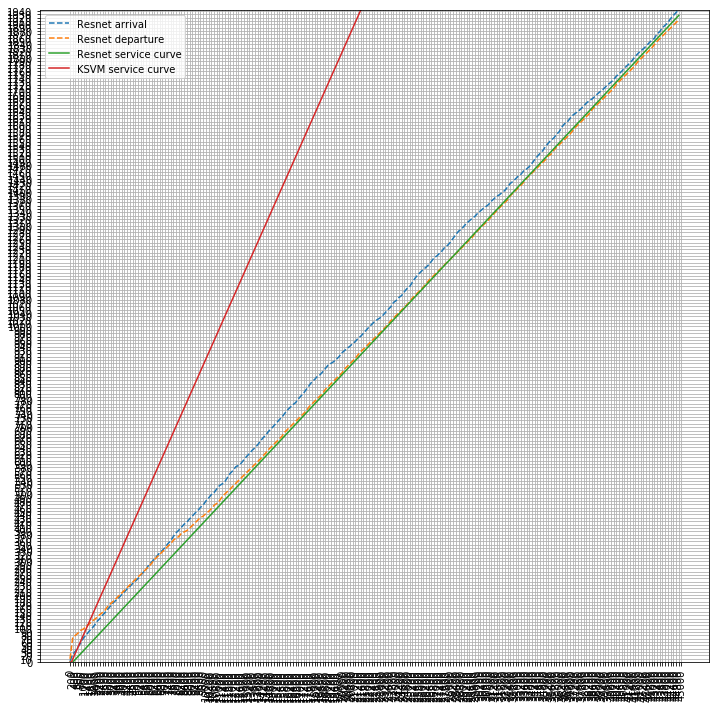

In [151]:
max(x_range)
plt.figure(figsize=(12,12))
plt.xticks(xrange(0,max(x_range)+200,200))
plt.xticks(rotation=90)
plt.gca().set_ylim([0,y_arrival_resnet[-1]])
plt.yticks(xrange(0,y_arrival_resnet[-1],10))
plt.grid(True)
plt.plot(x_arrival_resnet, y_arrival_resnet, label="Resnet arrival", linestyle="--")
# plt.plot(x_arrival_resnet_clipper, y_arrival_resnet_clipper, label="Resnet arrival clipper", linestyle="--")
plt.plot(x_departure_resnet, y_departure_resnet, label="Resnet departure", linestyle="--")
plt.plot([0,200,max(x_range)],[0,0,max(x_range)/1000.*43], label="Resnet service curve")
plt.plot([0,100,max(x_range)],[0,0,max(x_range)/1000.*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()

In [60]:
x_range = xrange(1,15000,25)
resnet2_arrival = ID1_500_hollistic_resnet2["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
# resnet2_departure = ID1_500_hollistic_resnet2["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet2, y_arrival_resnet2 = get_max_curve(resnet2_arrival, x_range)
# x_departure_resnet2, y_departure_resnet2 = get_max_curve(resnet2_departure, x_range)

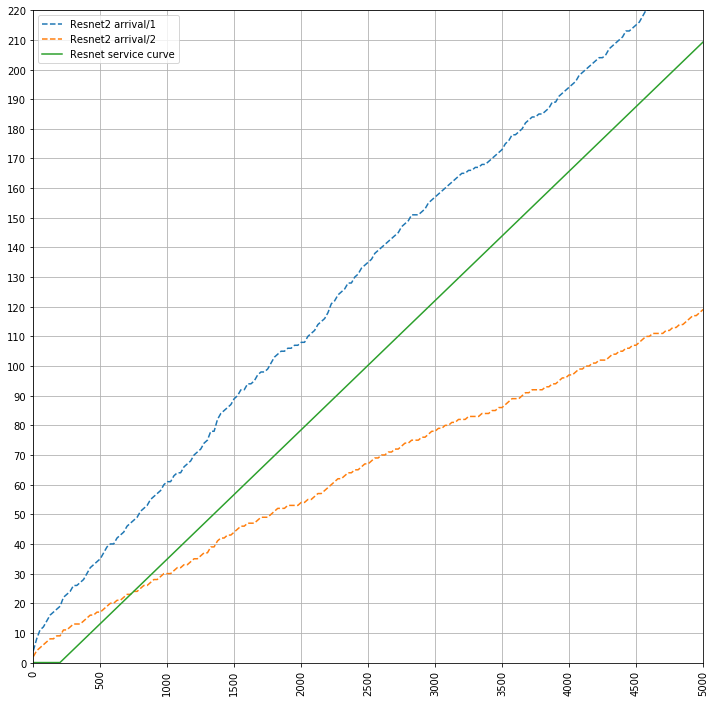

In [79]:
plt.figure(figsize=(12,12))
plt.xticks(xrange(0,max(x_range),500))
plt.xticks(rotation=90)
plt.yticks(xrange(0,np.max(y_arrival_resnet2),10))
plt.gca().set_xlim([0,5000])
plt.gca().set_ylim([0,220])
plt.grid(True)
plt.plot(x_arrival_resnet2, y_arrival_resnet2, label="Resnet2 arrival/1", linestyle="--")
plt.plot(x_arrival_resnet2, y_arrival_resnet2/2, label="Resnet2 arrival/2", linestyle="--")
plt.plot([0,200,max(x_range)],[0,0,max(x_range)/1000.*43], label="Resnet service curve")
# plt.plot([0,100,5000],[0,0,5*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()